# Import Libraries

In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from imblearn.over_sampling import SMOTE
from scipy import stats
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , cross_val_score , RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score , classification_report , accuracy_score , confusion_matrix 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
import catboost as cb
import tensorflow as tf
from keras import callbacks
from keras.layers import Dense, Input, Dropout, Normalization, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
tf.random.set_seed(42)
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV

# Data Cleaning

## Load the dataset
This dataset is taken from the Kaggle page 'https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/data'.

This dataset comprises about 10 years of daily weather observations from numerous locations across Australia. The observations were gathered from a multitude of weather stations. You can access daily observations from 'http://www.bom.gov.au/climate/data'.

In [335]:
# Load the dataset into a dataframe
df = pd.read_csv('weatherAUS.csv')

## Information about the data
On this section we will explorate how is the dataset composed and how many columns and rows does it have. After that we will check the quality of the data investigating on the nan values.

### First Look

In [336]:
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

### Size

In [337]:
df.shape

(145460, 23)

The dataset is composed by 145460 rows and 23 columns.

## Data Cleaning

In [338]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

We transform columns 'RainToday' and 'RainTomorrow' into boolean value.

In [339]:
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})

### Check for NaN values

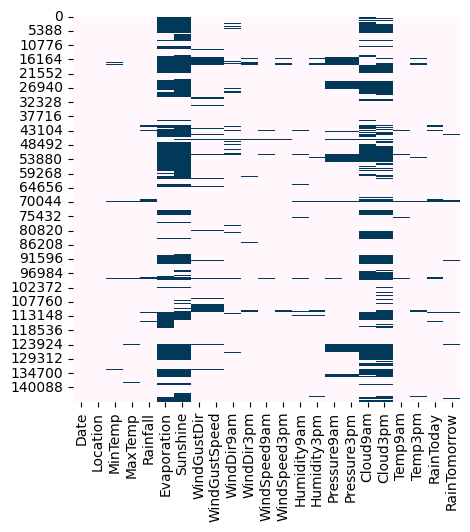

In [340]:
plt.figure(figsize=(5,5))
sns.heatmap(df.isnull(), cbar=False, cmap='PuBu')
plt.show()

In [341]:
# create a table with data missing 
missing_values = df.isnull().sum() # missing values

percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing , 
     'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame

missing_values   percent_missing % data type
Date                         0           0.000000    object
Location                     0           0.000000    object
MinTemp                   1485           1.020899   float64
MaxTemp                   1261           0.866905   float64
Rainfall                  3261           2.241853   float64
Evaporation              62790          43.166506   float64
Sunshine                 69835          48.009762   float64
WindGustDir              10326           7.098859    object
WindGustSpeed            10263           7.055548   float64
WindDir9am               10566           7.263853    object
WindDir3pm                4228           2.906641    object
WindSpeed9am              1767           1.214767   float64
WindSpeed3pm              3062           2.105046   float64
Humidity9am               2654           1.824557   float64
Humidity3pm               4507           3.098446   float64
Pressure9am              15065          10.356799   float64
Pressure3pm              15028          10.331363   float64
Cloud9am                 55888          38.421559   float64
Cloud3pm                 59358          40.807095   float64
Temp9am                   1767           1.214767   float64
Temp3pm                   3609           2.481094   float64
RainToday                 3261           2.241853   float64
RainTomorrow              3267           2.245978   float64

### FInding all the categorical and continuos features

In [342]:
categorical, contin=[],[]

for i in df.columns:
    
    if df[i].dtype == 'object':
        categorical.append(i)
    else:
        contin.append(i)
        
print(categorical)
print(contin)

['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


### Explore Problems within categorical features

Missing values in categorical features

In [343]:
(df[categorical].isnull().sum()/len(df[categorical]))

Date           0.000000
Location       0.000000
WindGustDir    0.070989
WindDir9am     0.072639
WindDir3pm     0.029066
dtype: float64

We can fill missing values in categorical features with the mode

In [344]:
for i in categorical:
    df[i].fillna(df[i].mode()[0], inplace=True)

And we convert them into continuous

In [345]:
lencoders = {}
for col in df.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    df[col] = lencoders[col].fit_transform(df[col])

### Explore Problems with numerical features

In [346]:
(df[contin].isnull().sum()/len(df[contin]))

MinTemp          0.010209
MaxTemp          0.008669
Rainfall         0.022419
Evaporation      0.431665
Sunshine         0.480098
WindGustSpeed    0.070555
WindSpeed9am     0.012148
WindSpeed3pm     0.021050
Humidity9am      0.018246
Humidity3pm      0.030984
Pressure9am      0.103568
Pressure3pm      0.103314
Cloud9am         0.384216
Cloud3pm         0.408071
Temp9am          0.012148
Temp3pm          0.024811
RainToday        0.022419
RainTomorrow     0.022460
dtype: float64

Since columns 'RainToday' and 'RainTomorrow' contain only binary values, we can fill NaN values with the mode.

In [347]:
df = df.dropna(subset=['RainToday', 'RainTomorrow'])

For the other values we use the **Multiple Imputation by Chained Equations (MICE)**. In particular this process is caracterised by the folllowing steps:
- Firstly all NaN values are initialised with the mean, median or a random variable
- For each variable with missing values, the imputator builds a regression model. This model uses the other variables in the dataset as predictors.
- The cycle continues until all missing values in all variables have been imputed.
- The process can be repeated for several iterations. At each iteration, the imputed values can be refined using the improved information from the previous imputations.
- The algorithm can continue to iterate until a convergence criterion is reached, or up to a maximum number of iterations. 

In [348]:
# Multiple Imputation by Chained Equations
mice_imputer = IterativeImputer(max_iter=1000)
df.iloc[:,:] = mice_imputer.fit_transform(df)

#for i in contin:
    #df[i].fillna(df[i].median(), inplace=True)

Final check

In [349]:
# create a table with data missing 
missing_values=df.isnull().sum() # missing values

percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing , 
     'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame

missing_values   percent_missing % data type
Date                         0                0.0     int64
Location                     0                0.0     int64
MinTemp                      0                0.0   float64
MaxTemp                      0                0.0   float64
Rainfall                     0                0.0   float64
Evaporation                  0                0.0   float64
Sunshine                     0                0.0   float64
WindGustDir                  0                0.0     int64
WindGustSpeed                0                0.0   float64
WindDir9am                   0                0.0     int64
WindDir3pm                   0                0.0     int64
WindSpeed9am                 0                0.0   float64
WindSpeed3pm                 0                0.0   float64
Humidity9am                  0                0.0   float64
Humidity3pm                  0                0.0   float64
Pressure9am                  0                0.0   float64
Pressure3pm                  0                0.0   float64
Cloud9am                     0                0.0   float64
Cloud3pm                     0                0.0   float64
Temp9am                      0                0.0   float64
Temp3pm                      0                0.0   float64
RainToday                    0                0.0   float64
RainTomorrow                 0                0.0   float64

Now we can see that there aren't NaN values anymore

### Outliers

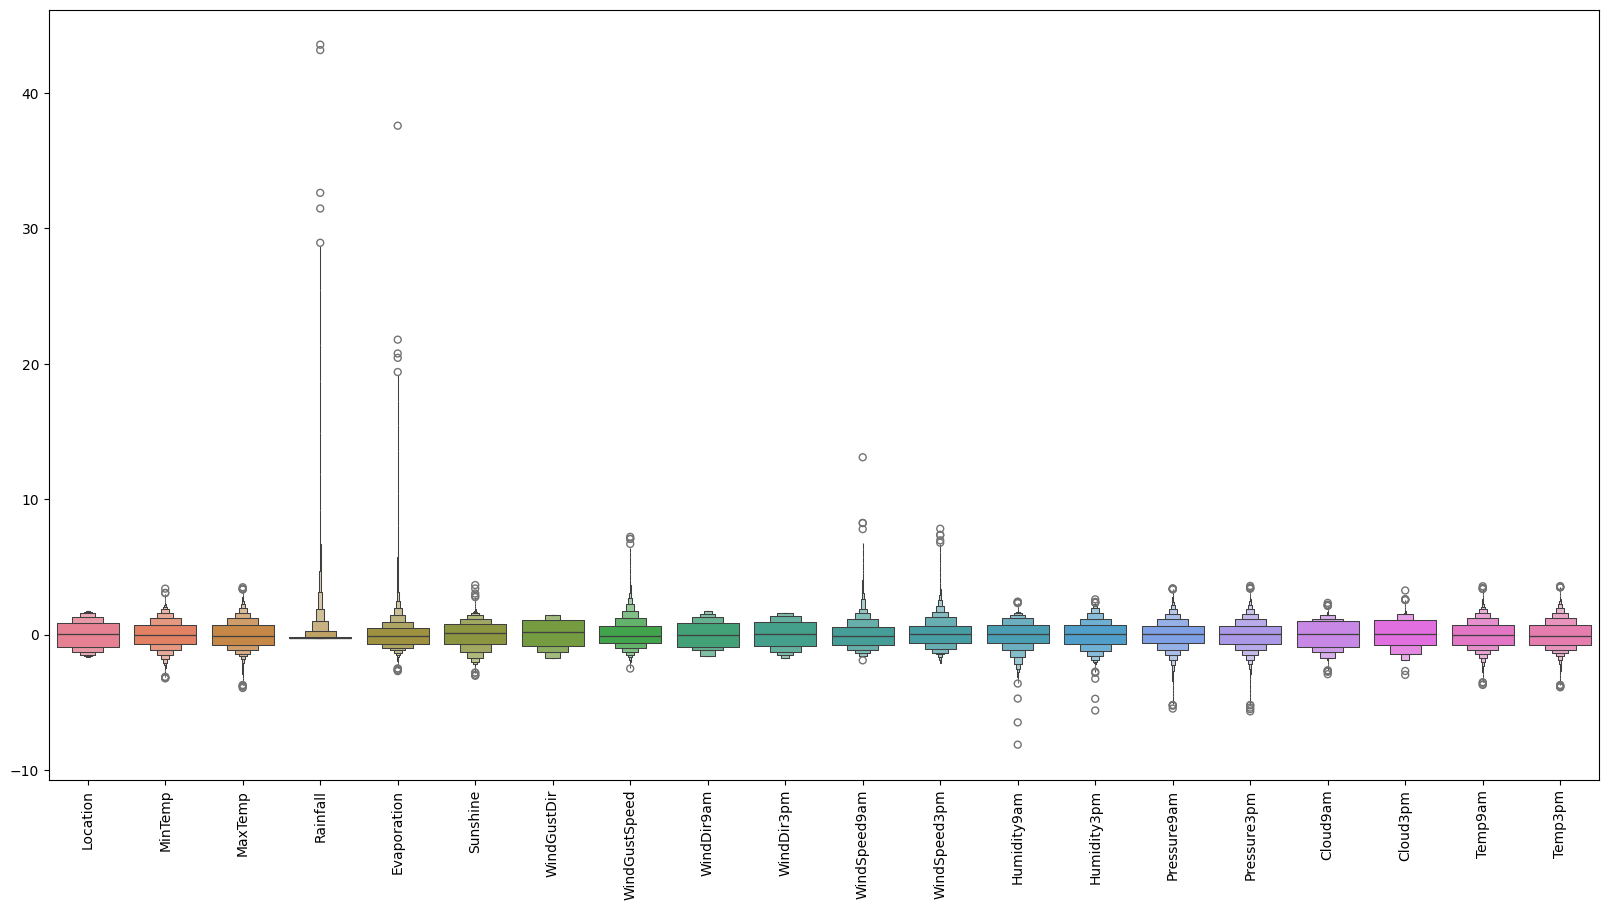

In [350]:
# Prepairing attributes of scale data

features = df.drop(['RainTomorrow','RainToday','Date'], axis=1) # dropping target and extra columns

# Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

#Detecting outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

From this first chart we can see that, in particular, columns 'Rainfall', 'Evaporation' and 'WindSpeed9am' are caracterised with an high value of outliers.

Now, in order to fix outliers, we add three functions:
- **outlier_thresholds**: this function calculates, for the specific column of the dataset, its first and third quantile and the Interquantile Range (IQR). It is defined as the range between the first quartile (Q1) and the third quartile (Q3) in a dataset. To find the boundaries for identifying potential outliers based on the IQR, a common rule of thumb is to consider values outside the range: $$[Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]$$
- **check_outliers**: this function verifies that in a specific column there are outliers by checking if there are values outside the previous range. It returns True if there are outliers in that specific column otherwise False
- **replace_with_thresholds**: a common practice is the replace outliers with the specific threshold. In particular, values that are lower than the lower bound are substituted with the lower bound and values that are bigger than the upper bound are replaced with the upper bound.

In [351]:
# Outlier Equation
def outlier_thresholds (dataframe, column, q1=0.25, q3=0.75) :
    quartile1 = dataframe[column].quantile(q1)
    quartile3 = dataframe[column].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

# Checking Outliers
def check_outlier(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    outliers = (dataframe[column] > up_limit) | (dataframe[column] < low_limit)
    if outliers.any():
        return True
    else:
        return False

# Replace with threshold
def replace_with_thresholds (dataframe, column) :
    low_limit , up_limit = outlier_thresholds(dataframe, column)
    dataframe.loc[(dataframe[column] < low_limit), column] = low_limit
    dataframe.loc[(dataframe[column] > up_limit), column] = up_limit

# Replace with median
def replace_with_median(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    median_value = dataframe[column].mean()
    dataframe.loc[(dataframe[column] < low_limit), column] = median_value
    dataframe.loc[(dataframe[column] > up_limit), column] = median_value

In [352]:
print('Before removing the outliers :')
for column in (df.drop(columns = ['RainTomorrow', 'RainToday', 'Date', 'Location']).columns):
    print(column, check_outlier(df, column))

print('Before delecting outliers the dataset contains', df.shape[0], 'rows')

Before removing the outliers :
MinTemp True
MaxTemp True
Rainfall True
Evaporation True
Sunshine True
WindGustDir False
WindGustSpeed True
WindDir9am False


WindDir3pm False
WindSpeed9am True
WindSpeed3pm True
Humidity9am True
Humidity3pm True
Pressure9am True
Pressure3pm True
Cloud9am False
Cloud3pm False
Temp9am True
Temp3pm True
Before delecting outliers the dataset contains 140787 rows


In [353]:
print('After removing the outliers :')
for column in (df.drop(columns = ['RainTomorrow', 'RainToday', 'Date', 'Location']).columns):
    replace_with_thresholds(df, column)
    print(column, check_outlier(df, column))

print('After delecting outliers the dataset contains', df.shape[0], 'rows')

After removing the outliers :
MinTemp False
MaxTemp False
Rainfall False


Evaporation False
Sunshine False
WindGustDir False
WindGustSpeed False
WindDir9am False
WindDir3pm False
WindSpeed9am False
WindSpeed3pm False
Humidity9am False
Humidity3pm False
Pressure9am False
Pressure3pm False
Cloud9am False
Cloud3pm False
Temp9am False
Temp3pm False
After delecting outliers the dataset contains 140787 rows


Final check

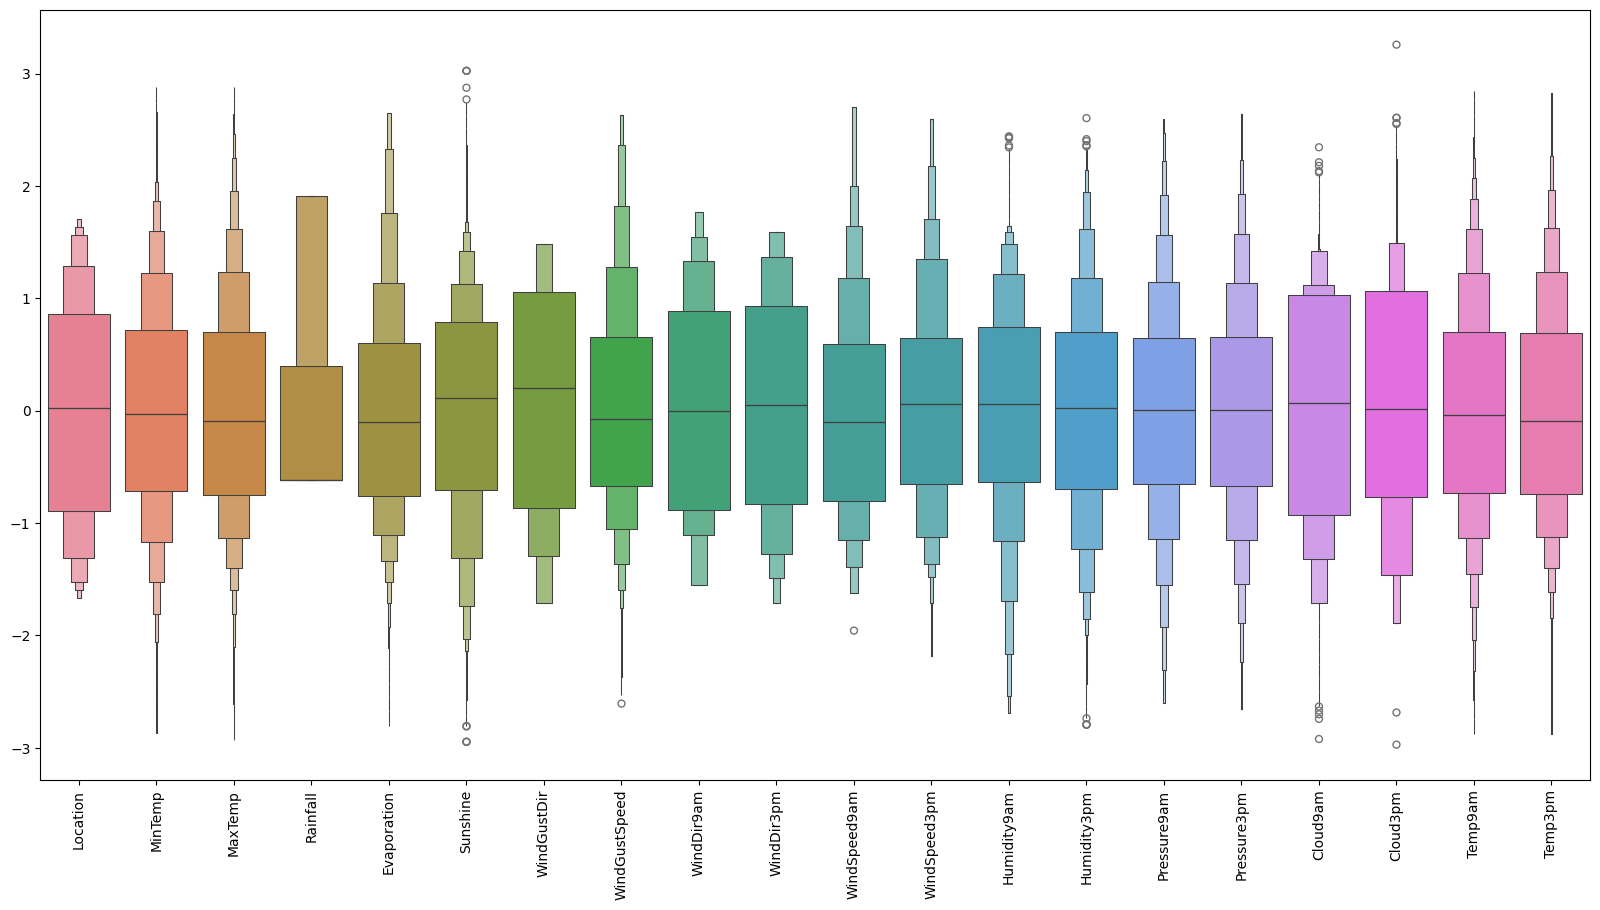

In [354]:
features = df.drop(['RainTomorrow','RainToday','Date'], axis=1) # dropping target and extra columns

# Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

#Detecting outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

### Multicollinearity Problem

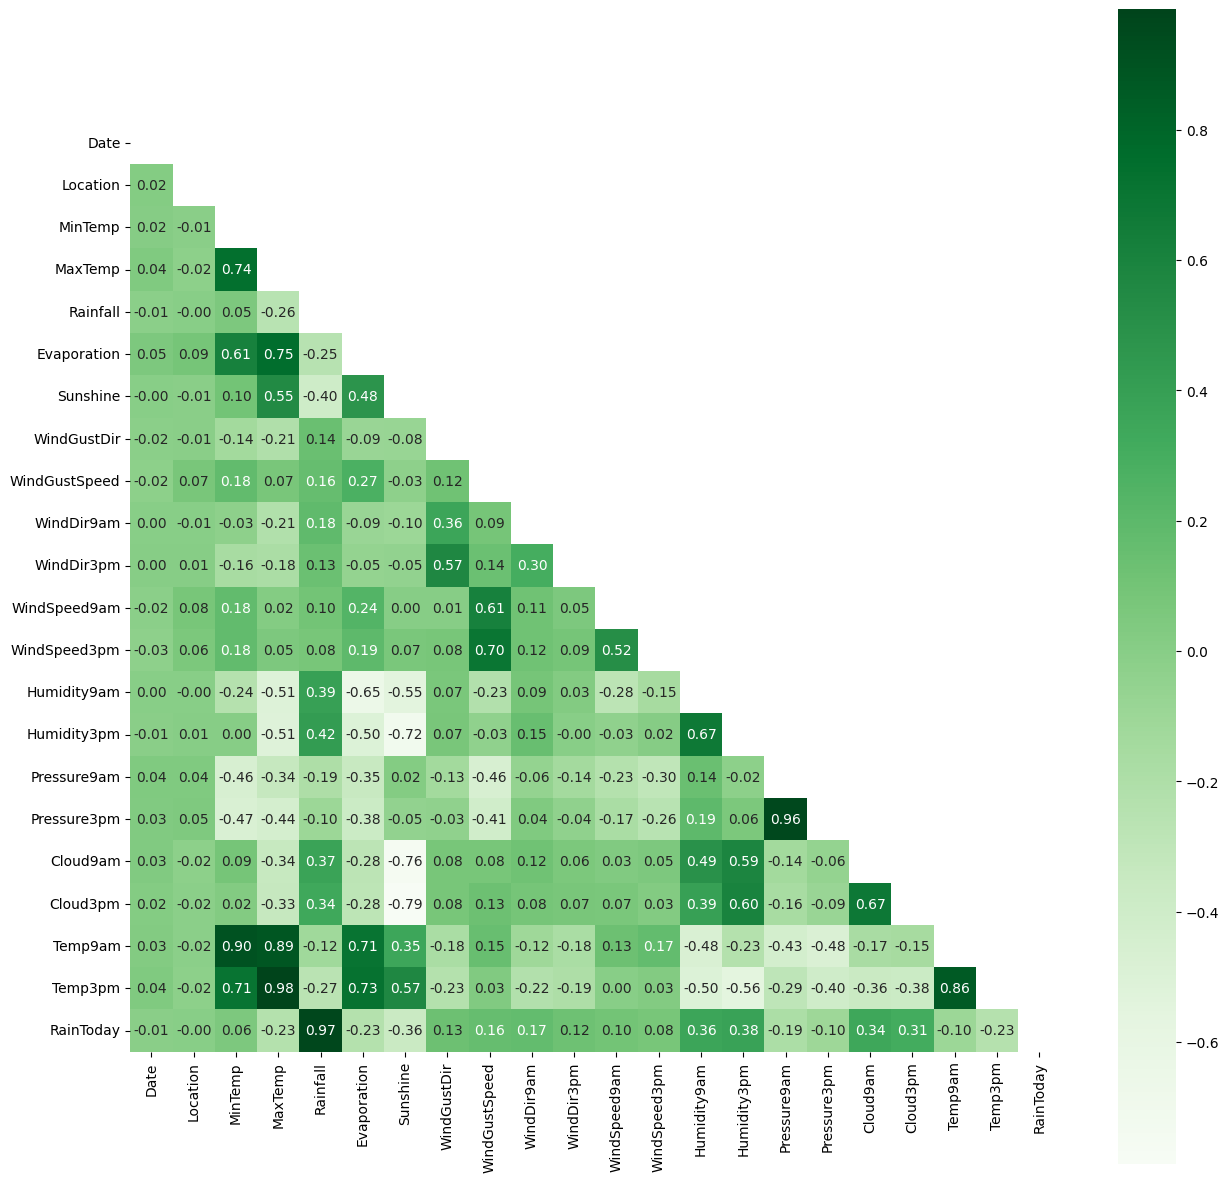

In [355]:
corr = df.drop('RainTomorrow', axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(15,15))
ax = sns.heatmap(corr, mask=mask, square=True, annot=True, fmt='.2f', cmap='Greens')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

From the matrix we can observe that some features are higly correlated. So, we can adopt the **VIF** method or Variance Inflaction Factor. In VIF method, we pick each feature and regress it against all of the other features. For each regression, the factor is calculated as :
$$ VIF = \frac{1}{1 - R^2}$$
As we see from the formula, greater the value of $R^2$, greater is the $VIF$. Hence, greater VIF denotes greater correlation.


In [356]:
# Aggiungere una costante per rappresentare l'intercetta
X = add_constant(df.drop(['RainTomorrow'], axis=1))

# Calcolare il VIF per ogni variabile
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


          feature           VIF
0           const  43000.933464
1            Date      1.019089
2        Location      1.048043
3         MinTemp     10.915623
4         MaxTemp     49.509326
5        Rainfall     16.580866
6     Evaporation      3.826661
7        Sunshine      5.563556
8     WindGustDir      1.626109
9   WindGustSpeed      3.057047
10     WindDir9am      1.296399
11     WindDir3pm      1.650072
12   WindSpeed9am      1.946910
13   WindSpeed3pm      2.283799
14    Humidity9am      4.634240
15    Humidity3pm      6.831019
16    Pressure9am     24.275623
17    Pressure3pm     23.138382
18       Cloud9am      2.941021
19       Cloud3pm      3.098813
20        Temp9am     23.135183
21        Temp3pm     55.815780
22      RainToday     15.481261


Now, step by step, we select the variable with the highest VIP value and we remove it. In this way, we saw that deleting 'Temp3pm', 'Temp9am', 'Pressure9am' and 'Rainfall' features produced an important decrease.

In [357]:
# Rimuovere variabili con VIF alto
df_reduced = df.drop(['Temp3pm', 'Pressure9am', 'Temp9am', 'Rainfall'], axis=1)

# Calcolare di nuovo il VIF per le variabili rimanenti
X_reduced = add_constant(df_reduced.drop(['RainTomorrow'], axis=1))
vif_data_reduced = pd.DataFrame()
vif_data_reduced["feature"] = X_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

print(vif_data_reduced)


          feature           VIF
0           const  40994.929955
1            Date      1.017247
2        Location      1.047645
3         MinTemp      5.633780
4         MaxTemp      8.086556
5     Evaporation      3.622636
6        Sunshine      5.388329
7     WindGustDir      1.609030
8   WindGustSpeed      2.967927
9      WindDir9am      1.275793
10     WindDir3pm      1.559342
11   WindSpeed9am      1.923658
12   WindSpeed3pm      2.205593
13    Humidity9am      2.857733
14    Humidity3pm      4.017702
15    Pressure3pm      1.686417
16       Cloud9am      2.897327
17       Cloud3pm      3.007988
18      RainToday      1.362563


So we can drop them

In [358]:
df.drop(['Temp3pm', 'Pressure9am', 'Temp9am', 'Rainfall'], axis=1, inplace=True)

# Machine Learning
Now we can focus our attention on predicting the target column 'RainTomorrow' by using different ML algorithm.

In [359]:
df.drop('Date',axis = 1, inplace = True)

## Data Preprocessing

From the chart we can see that we have the problem of **IMBALACED DATASET**.

This aspect is a problem in the field of Machine Learning because when we try to apply any prediction algorithm we will notice that it will predict the majority class well, but not the minority.

This is because the algorithm was trained on an instance that had a majority of 'NO' cases.

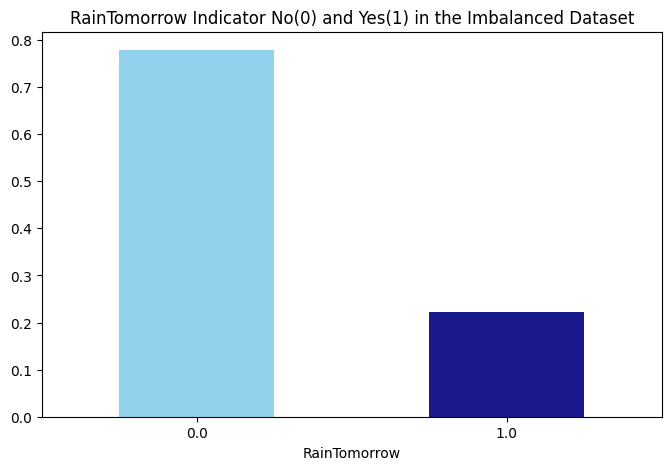

In [360]:
fig = plt.figure(figsize = (8,5))
df.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

But **BEFORE** trying to use some skills to avoid this problem we have to split the data into train and test set:

### Divide the data into train and test set

In [361]:
X = df.drop('RainTomorrow', axis = 1)
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=df['RainTomorrow'])

print('X_train size', X_train.shape)
print('y_train size', y_train.shape)
print('X_test size', X_test.shape)
print('y_test size', y_test.shape)

X_train size (105590, 17)
y_train size (105590,)
X_test size (35197, 17)
y_test size (35197,)


### Rebalance the data
Now we can try to apply some skills to avoid imbalanced dataset. We are going to use **SMOTE** and **UNDERSAMPLE** on the train set, not to the test set.

#### Synthetic Minority Oversampling Technique (SMOTE)
An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space

In [362]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class Distribution after SMOTE:", y_train_smote.value_counts())

print('X_train size', X_train_smote.shape)
print('y_train size', y_train_smote.shape)
print('X_test size', X_test.shape)
print('y_test size', y_test.shape)

Class Distribution after SMOTE: RainTomorrow
0.0    82189
1.0    82189
Name: count, dtype: int64
X_train size (164378, 17)
y_train size (164378,)
X_test size (35197, 17)
y_test size (35197,)


#### Undersample

In [363]:
rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print("Class Distribution after undersample:", y_train_under.value_counts())

print('X_train size', X_train_under.shape)
print('y_train size', y_train_under.shape)
print('X_test size', X_test.shape)
print('y_test size', y_test.shape)

Class Distribution after undersample: RainTomorrow
0.0    23401
1.0    23401
Name: count, dtype: int64
X_train size (46802, 17)
y_train size (46802,)
X_test size (35197, 17)
y_test size (35197,)


### Standardize them

In [364]:
# Standardize the original training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Standardize the SMOTE training set
scaler_smote = StandardScaler()
X_train_smote_scaled = scaler_smote.fit_transform(X_train_smote)
X_test_smote_scaled = scaler_smote.transform(X_test)

# Standardize the under-sampled training set
scaler_under = StandardScaler()
X_train_under_scaled = scaler_under.fit_transform(X_train_under)
X_test_under_scaled = scaler_under.transform(X_test)

### Model Evaluation Class

In [365]:
class Model:
    def __init__(self, model, name = None, scaled = True, resample = None):
        self.model = model
        self.name = name
        self.scaled = scaled
        self.resample = resample
    def fit(self):
        if self.scaled == True and self.resample == None:
            self.model.fit(X_train_scaled, y_train)
        if self.scaled == False and self.resample == None:
            self.model.fit(X_train, y_train)
        if self.scaled == True and self.resample == 'smote':
            self.model.fit(X_train_smote_scaled, y_train_smote)
        if self.scaled == False and self.resample == 'smote':
            self.model.fit(X_train_smote, y_train_smote)
        if self.scaled == True and self.resample == 'under':
            self.model.fit(X_train_under_scaled, y_train_under)
        if self.scaled == False and self.resample == 'under':
            self.model.fit(X_train_under, y_train_under)
    def __get_predictions(self):
        if self.scaled == True and self.resample == None:
            return self.model.predict(X_test_scaled), self.model.predict_proba(X_test_scaled)[:,1]
        if self.scaled == False and self.resample == None:
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
        if self.scaled == True and self.resample == 'smote':
            return self.model.predict(X_test_smote_scaled), self.model.predict_proba(X_test_smote_scaled)[:,1]
        if self.scaled == False and self.resample == 'smote':
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
        if self.scaled == True and self.resample == 'under':
            return self.model.predict(X_test_under_scaled), self.model.predict_proba(X_test_under_scaled)[:,1]
        if self.scaled == False and self.resample == 'under':
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
    def get_metrics(self) -> pd.Series:
        y_pred, y_probs = self.__get_predictions()
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        pr_auc = metrics.average_precision_score(y_test, y_probs)
        metrics_series = pd.Series({
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'Confusion Matrix': conf_mat,
            'PR AUC': pr_auc,
            'Name': self.name
        })
        if self.name == '' or self.name is None:
            metrics_series.Name =type(self.model).__name__
        return metrics_series
    
    def visualize_metrics(self):
        y_pred, y_probs = self.__get_predictions()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        # Calculate Precision-Recall curve and AUC
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_probs)
        pr_auc = metrics.auc(recall, precision)
        # Plot ROC curve
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 2, 1)
        plt.axis('equal')
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')

        # Plot Precision-Recall curve
        plt.subplot(2, 2, 2)
        plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')

        residuals = y_test - y_probs
        # Plot Confusion Matrix and Distribution of errors
        plt.subplot(2, 2, 3)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.subplot(2, 2, 4)
        sns.histplot(residuals, bins=30, edgecolor='black', kde=True)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Distribution of Errors')
        plt.show()

In [366]:
models_df = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])

models_df_smote = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])

models_df_under = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])

## Linear Discriminant Analysis (LDA)

### No resample

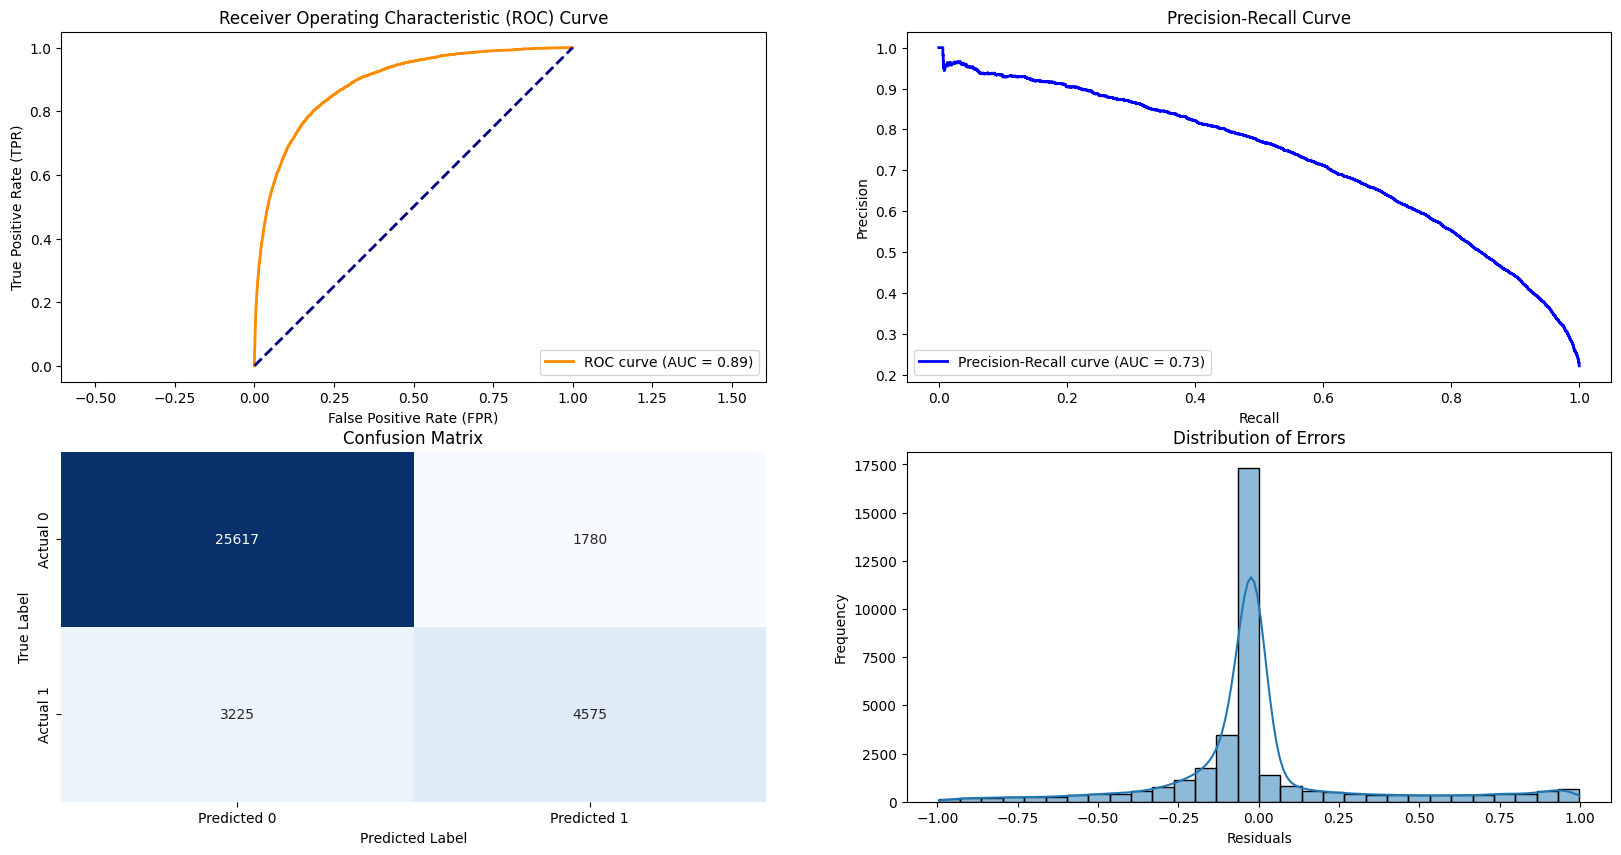

In [367]:
model = Model(LinearDiscriminantAnalysis(), name='LDA No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [368]:
metrics_LDA_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_LDA_no_resample.to_frame().T])
print(metrics_LDA_no_resample)

Accuracy                                   0.8578
Precision                                0.719906
Recall                                   0.586538
F1-Score                                 0.646415
ROC AUC                                  0.888577
Confusion Matrix    [[25617, 1780], [3225, 4575]]
PR AUC                                   0.727093
Name                              LDA No Resample
dtype: object


### SMOTE

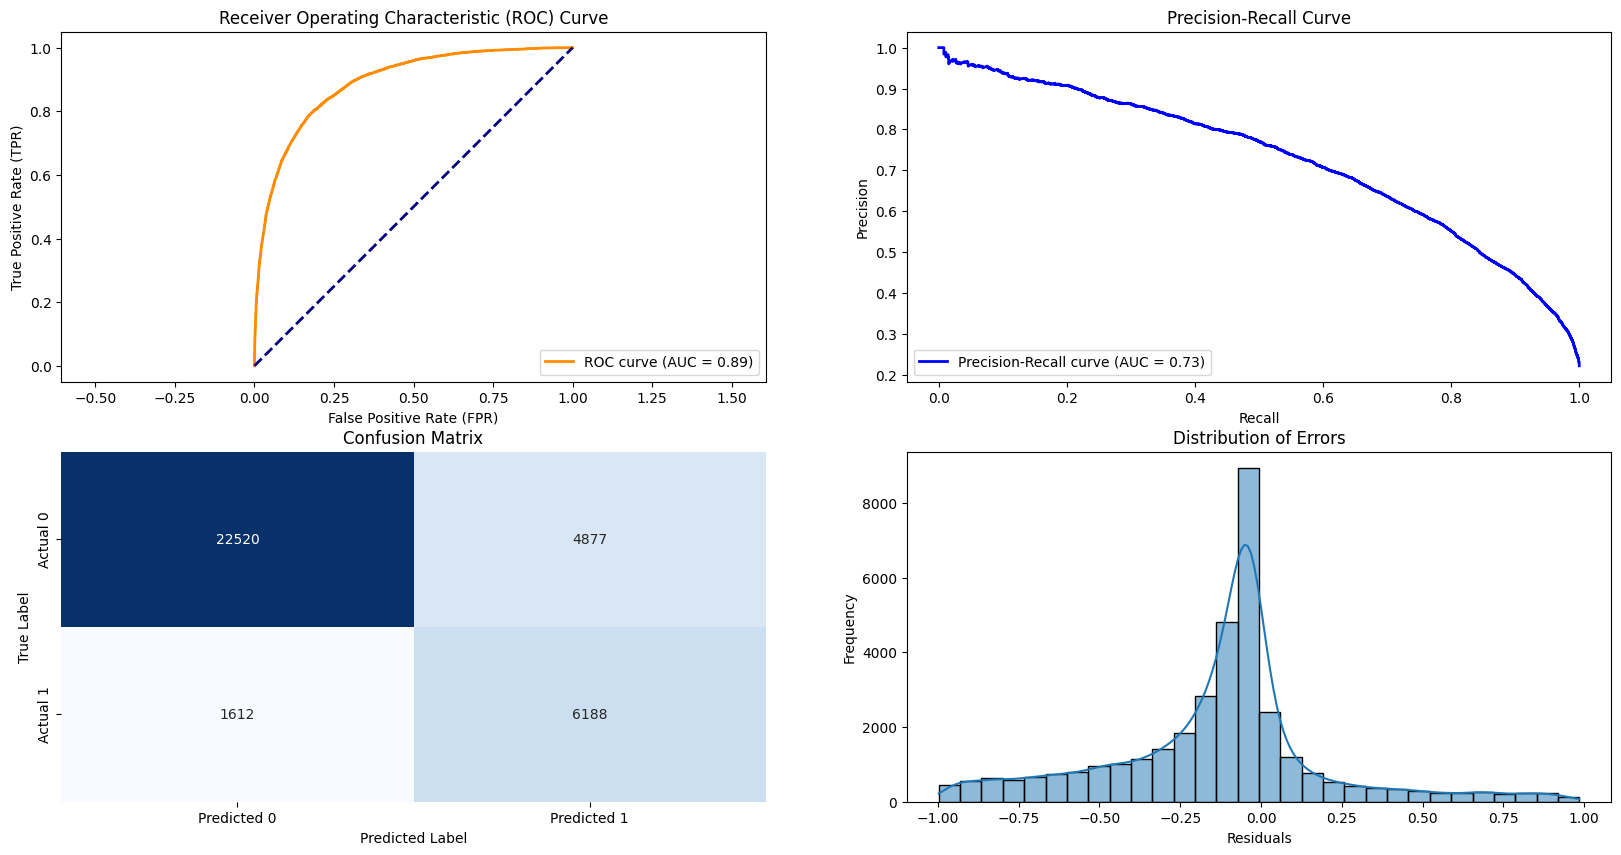

In [369]:
model = Model(LinearDiscriminantAnalysis(), name='LDA SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [370]:
metrics_LDA_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_LDA_smote.to_frame().T])
print(metrics_LDA_smote)

Accuracy                                 0.815638
Precision                                0.559241
Recall                                   0.793333
F1-Score                                  0.65603
ROC AUC                                   0.88886
Confusion Matrix    [[22520, 4877], [1612, 6188]]
PR AUC                                   0.726089
Name                                    LDA SMOTE
dtype: object


### Undersample

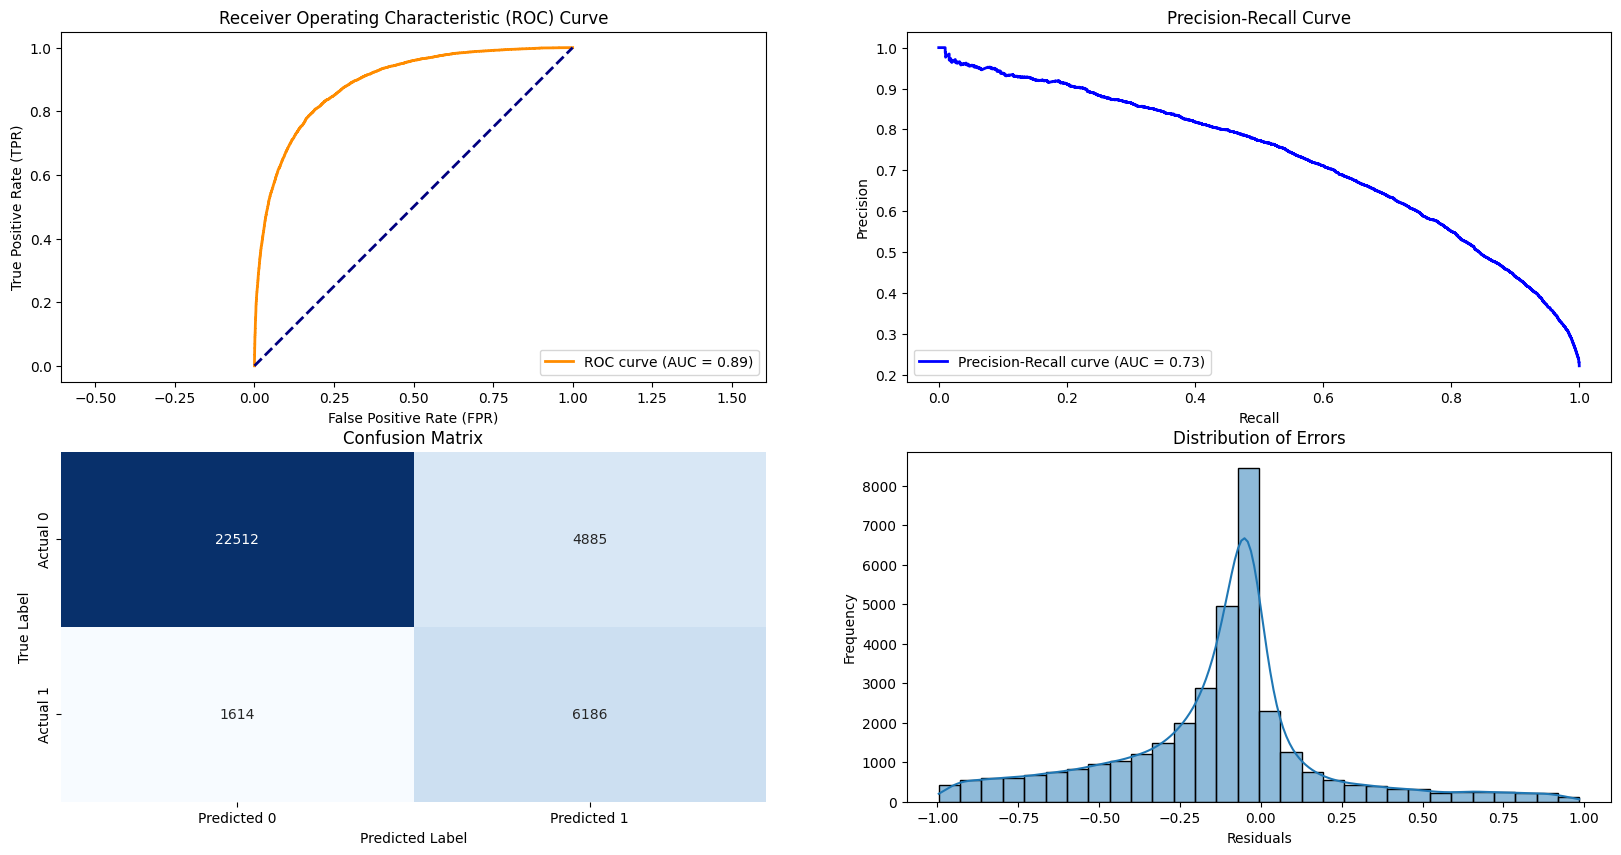

In [371]:
model = Model(LinearDiscriminantAnalysis(), name='LDA undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [372]:
metrics_LDA_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_LDA_under.to_frame().T])
print(metrics_LDA_under)

Accuracy                                 0.815354
Precision                                0.558757
Recall                                   0.793077
F1-Score                                 0.655609
ROC AUC                                  0.889342
Confusion Matrix    [[22512, 4885], [1614, 6186]]
PR AUC                                   0.727967
Name                              LDA undersample
dtype: object


## Logistic Regression

### No resample

In [373]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky','sag','saga']  # Optimization algorithm
}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_scaled, y_train)
best_lr_model = clf.best_estimator_

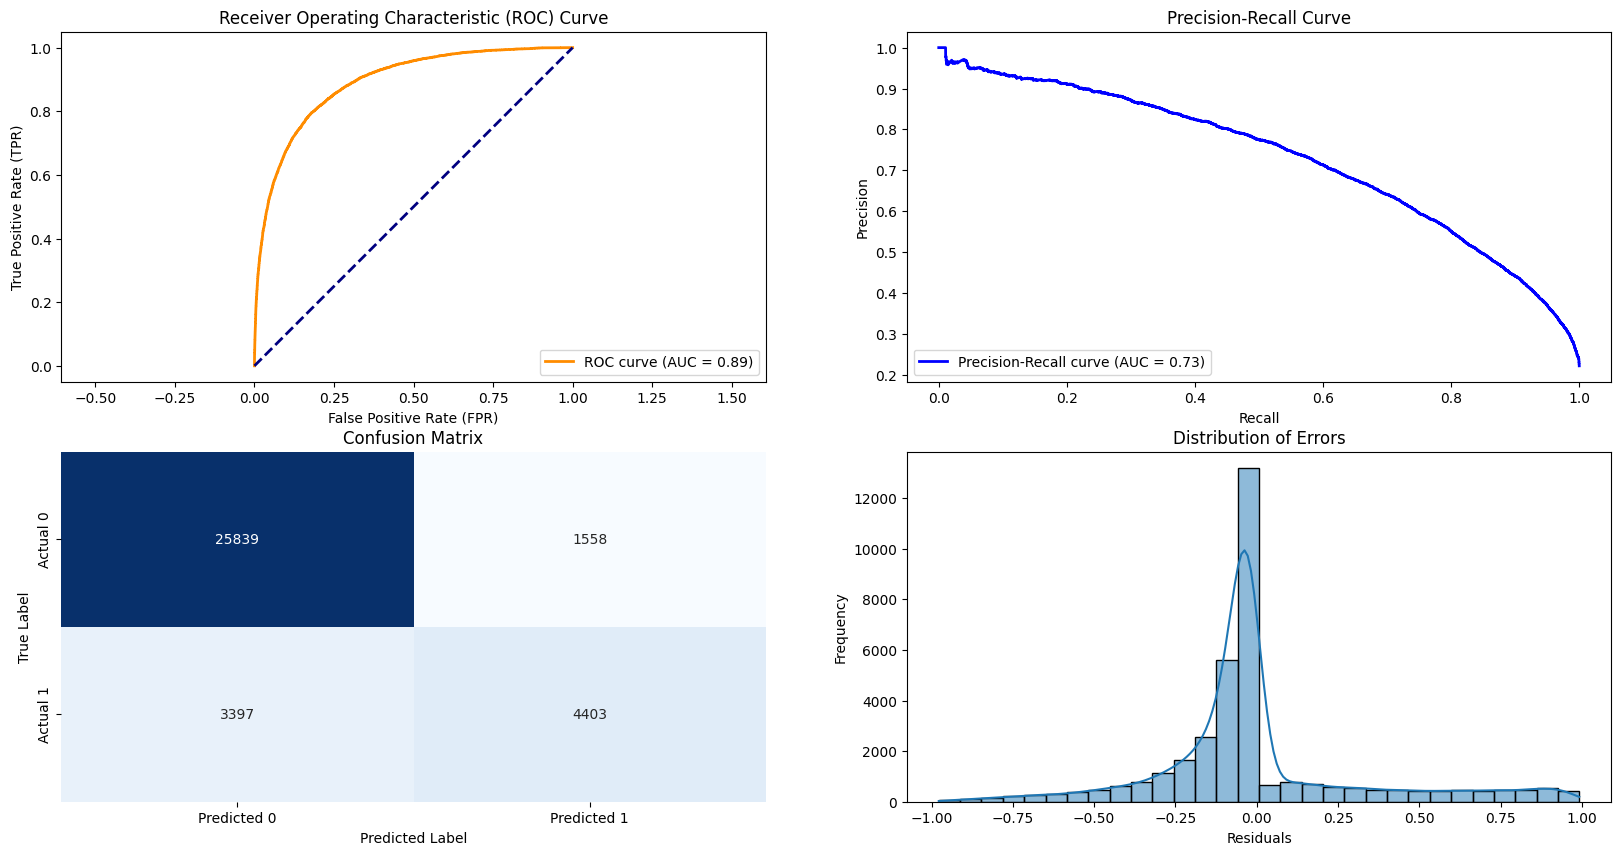

In [374]:
# Create the model
model = Model(best_lr_model, 
              name='Logistic Regression No Resample', 
              scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [375]:
metrics_LR_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_LR_no_resample.to_frame().T])
print(metrics_LR_no_resample)

Accuracy                                   0.859221
Precision                                  0.738634
Recall                                     0.564487
F1-Score                                   0.639924
ROC AUC                                    0.889739
Confusion Matrix      [[25839, 1558], [3397, 4403]]
PR AUC                                     0.729967
Name                Logistic Regression No Resample
dtype: object


### SMOTE

In [376]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky','sag','saga']  # Optimization algorithm
}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_smote_scaled, y_train_smote)
best_lr_model = clf.best_estimator_

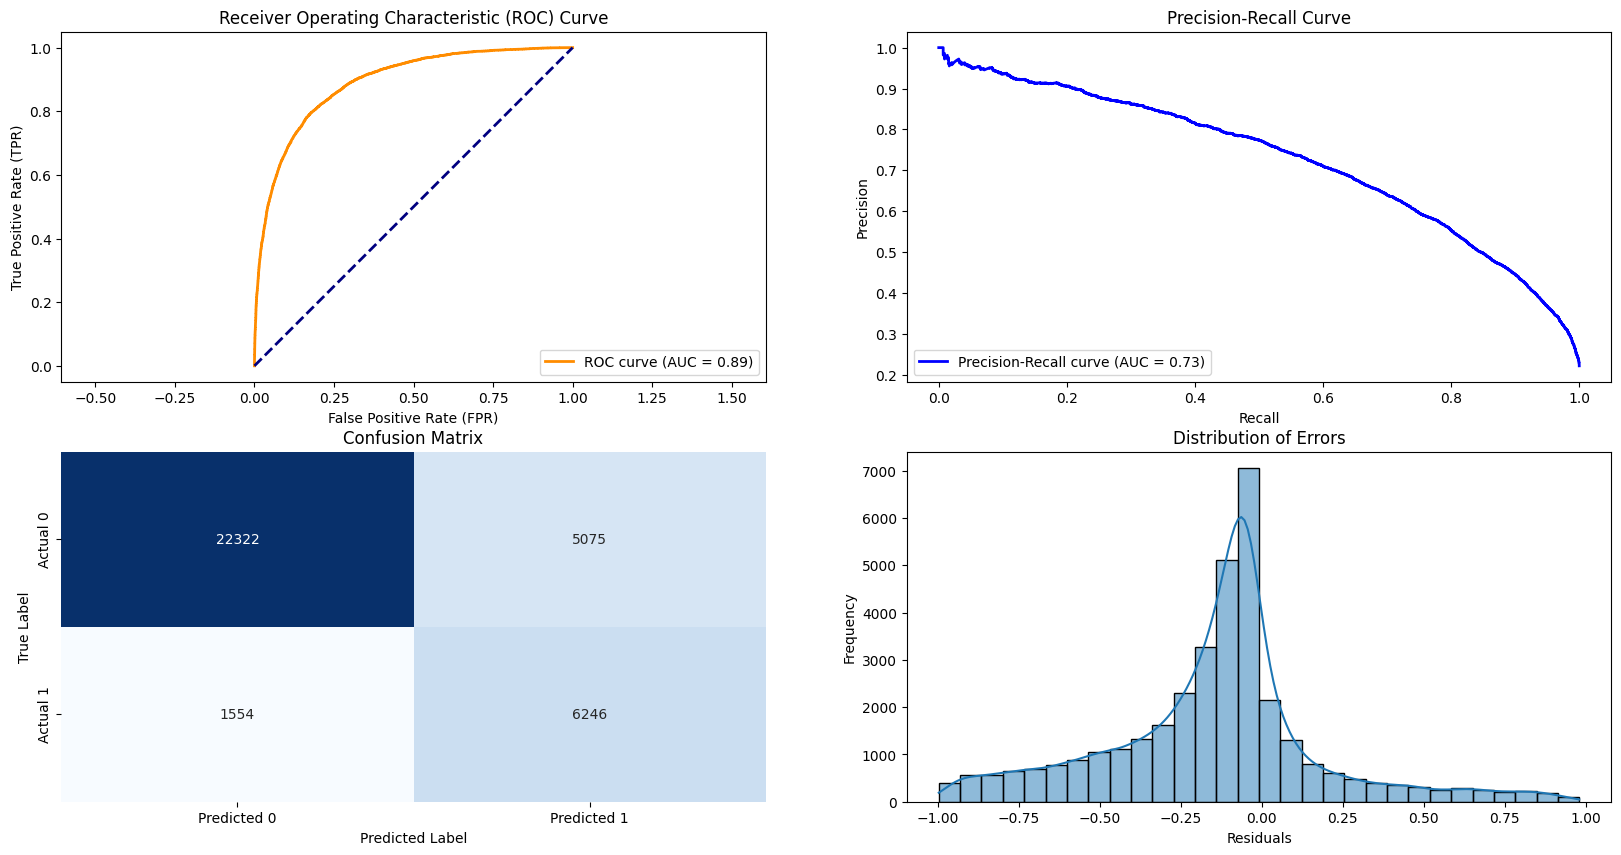

In [377]:
model = Model(best_lr_model, 
              name='Logistic Regression Smote', 
              scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [378]:
metrics_LR_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_LR_smote.to_frame().T])
print(metrics_LR_smote)

Accuracy                                  0.81166
Precision                                0.551718
Recall                                   0.800769
F1-Score                                 0.653313
ROC AUC                                  0.889469
Confusion Matrix    [[22322, 5075], [1554, 6246]]
PR AUC                                   0.726918
Name                    Logistic Regression Smote
dtype: object


### Undersample

In [379]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky','sag','saga']  # Optimization algorithm
}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_under_scaled, y_train_under)
best_lr_model = clf.best_estimator_

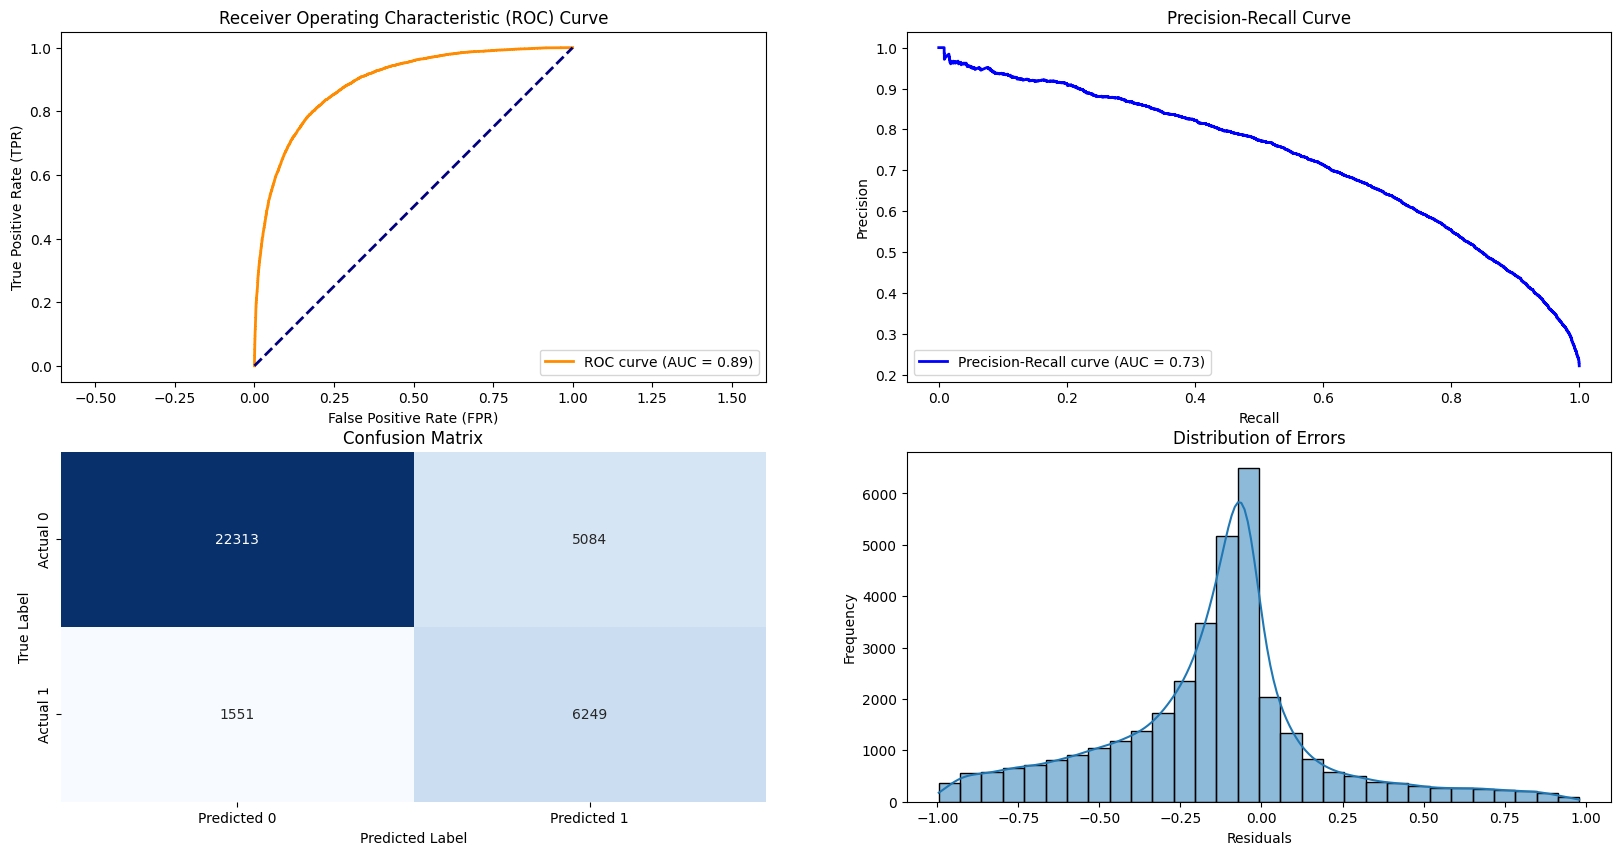

In [380]:
model = Model(best_lr_model, 
              name='Logistic Regression Undersample', 
              scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [381]:
metrics_LR_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_LR_under.to_frame().T])
print(metrics_LR_under)

Accuracy                                    0.81149
Precision                                  0.551399
Recall                                     0.801154
F1-Score                                   0.653217
ROC AUC                                    0.889934
Confusion Matrix      [[22313, 5084], [1551, 6249]]
PR AUC                                      0.72871
Name                Logistic Regression Undersample
dtype: object


## Decision Tree Classifier

### No Resample

In [382]:
from scipy.stats import randint

param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 40),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

dt = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(dt, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)


random_search.fit(X_train_scaled, y_train)
best_dt_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   2.5s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   2.5s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   2.5s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   2.6s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   2.8s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; total time=   2.9s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; total time=   2.9s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; total time=   2.9s
[CV] END criterion=entropy, max_depth=4, max_

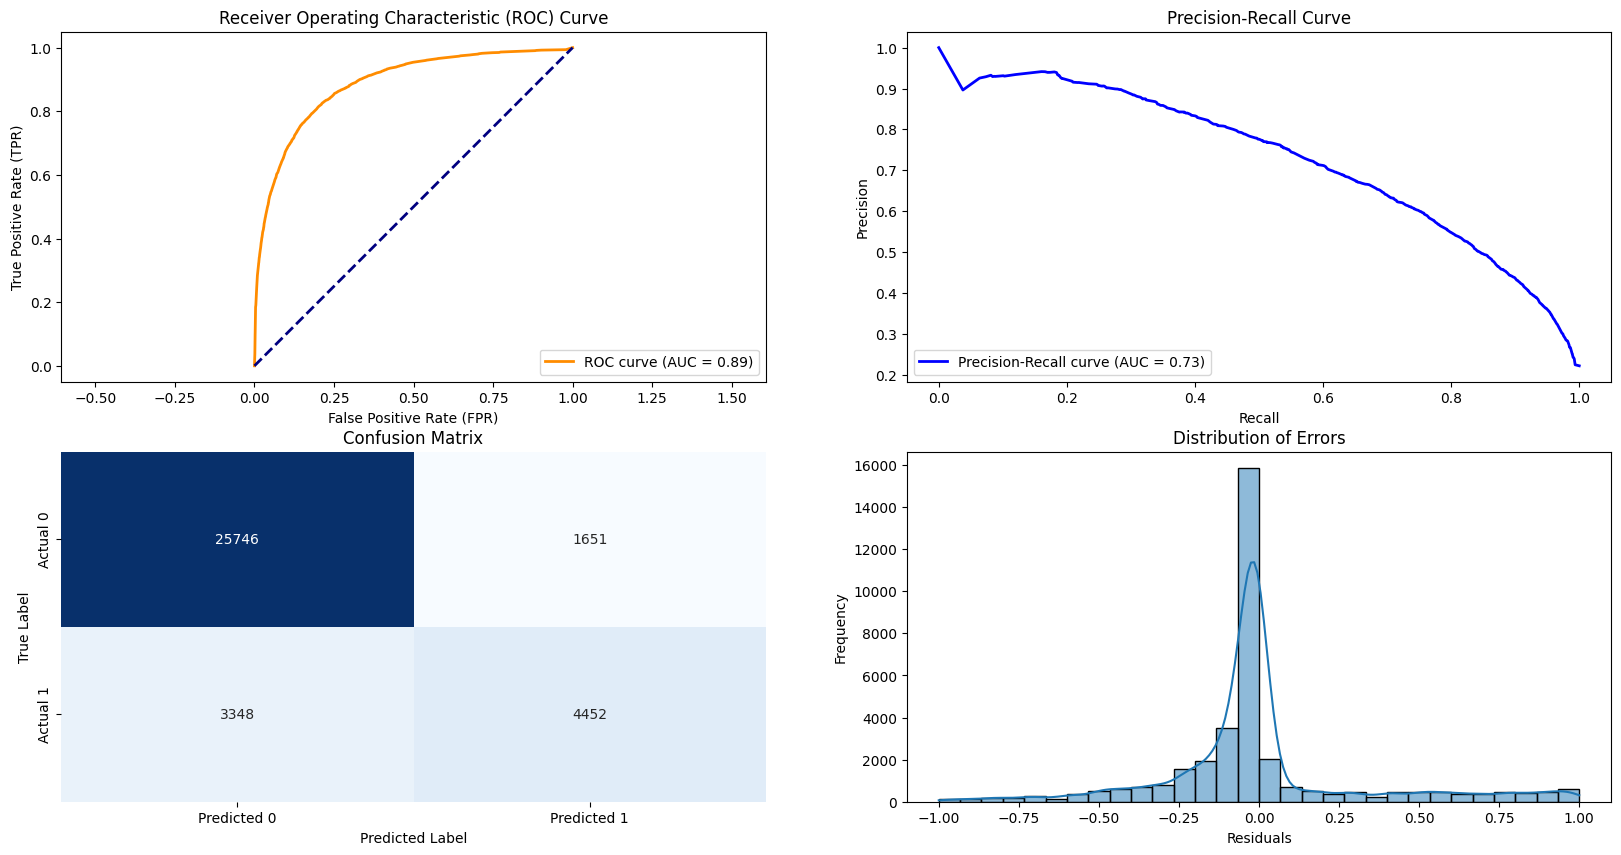

In [383]:
model = Model(best_dt_model, 
              name='DT No Resample', 
              scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [384]:
metrics_DT_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_DT_no_resample.to_frame().T])
print(metrics_DT_no_resample)

Accuracy                                 0.857971
Precision                                0.729477
Recall                                   0.570769
F1-Score                                 0.640437
ROC AUC                                   0.88525
Confusion Matrix    [[25746, 1651], [3348, 4452]]
PR AUC                                   0.726767
Name                               DT No Resample
dtype: object


### SMOTE

In [385]:
param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 40),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

dt = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(dt, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)


random_search.fit(X_train_smote_scaled, y_train_smote)
best_dt_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   4.6s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   4.7s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   4.6s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   4.9s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   4.5s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; total time=   4.8s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; total time=   4.9s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; t

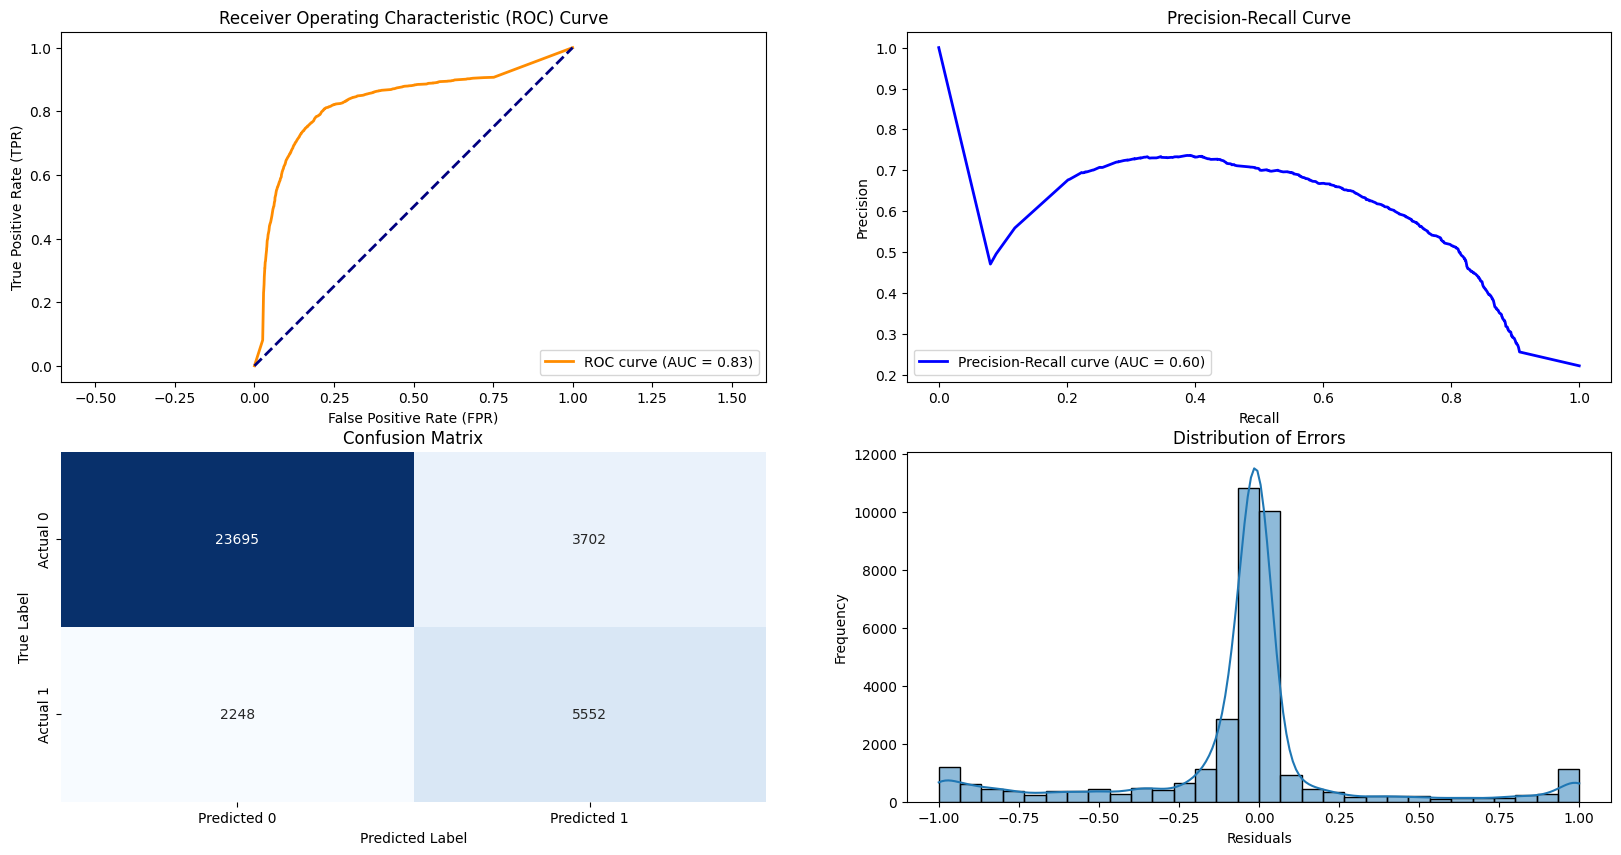

In [386]:
model = Model(best_dt_model, 'DT Smote', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [387]:
metrics_DT_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_DT_smote.to_frame().T])
print(metrics_DT_smote)

Accuracy                                 0.830952
Precision                                0.599957
Recall                                   0.711795
F1-Score                                 0.651108
ROC AUC                                  0.826855
Confusion Matrix    [[23695, 3702], [2248, 5552]]
PR AUC                                   0.581907
Name                                     DT Smote
dtype: object


### Undersample

In [388]:
param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 40),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

dt = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(dt, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)


random_search.fit(X_train_under_scaled, y_train_under)
best_dt_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   0.9s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   0.9s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   0.9s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   0.9s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; total time=   1.2s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   1.2s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; total time=   1.2s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; t

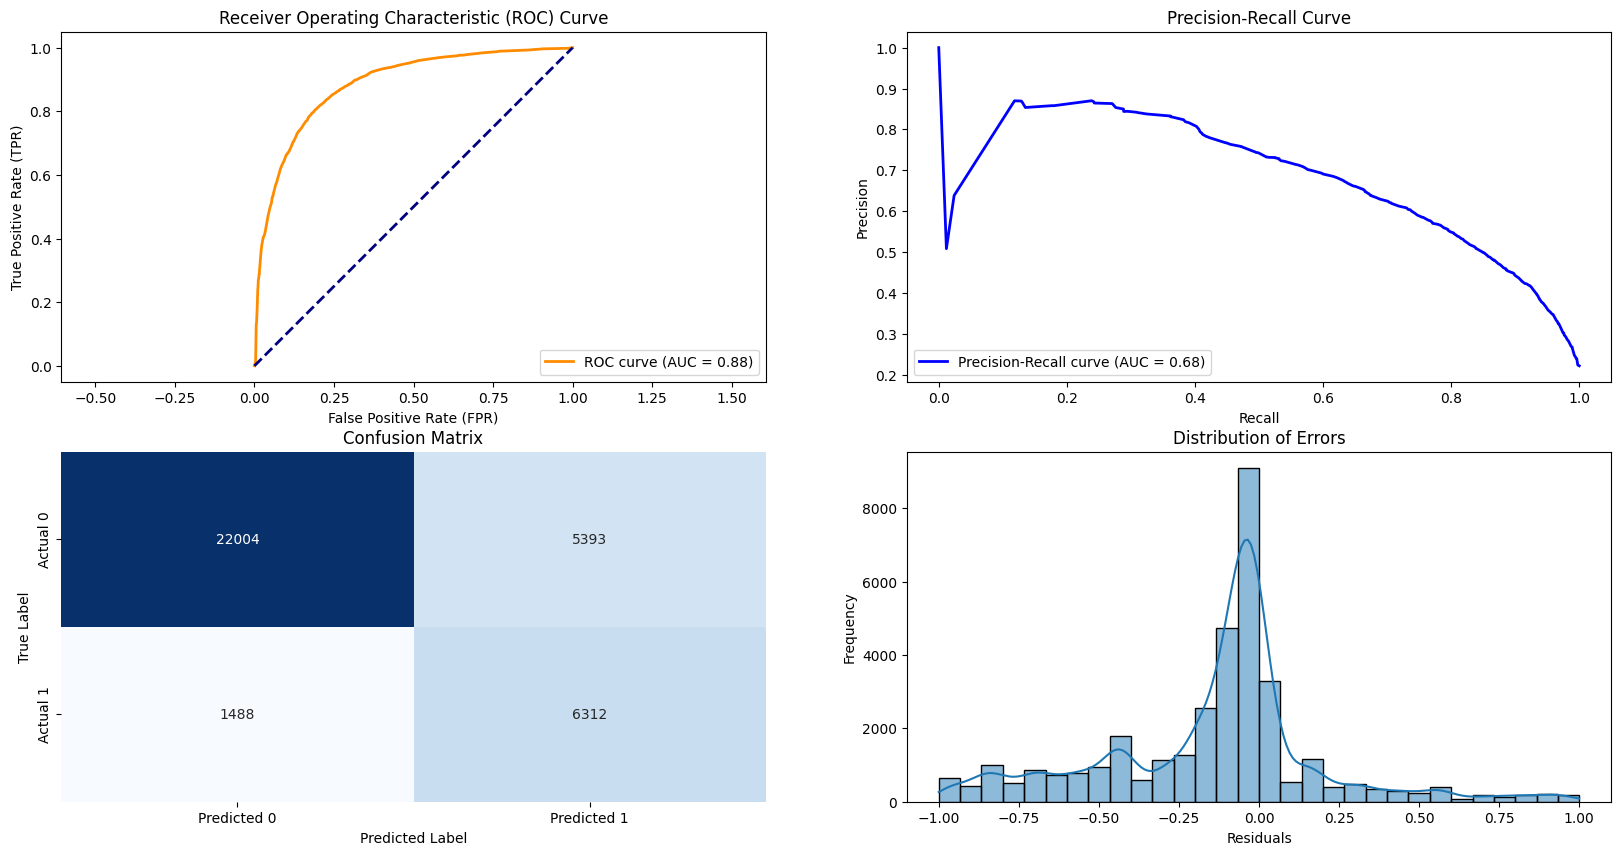

In [389]:
model = Model(best_dt_model, name='DT Undersample', scaled=False, resample='under')
model.fit()
model.visualize_metrics()

In [390]:
metrics_DT_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_DT_under.to_frame().T])
print(metrics_DT_under)

Accuracy                                   0.8045
Precision                                0.539257
Recall                                   0.809231
F1-Score                                 0.647219
ROC AUC                                  0.883556
Confusion Matrix    [[22004, 5393], [1488, 6312]]
PR AUC                                   0.692408
Name                               DT Undersample
dtype: object


## KNN

### No Resample

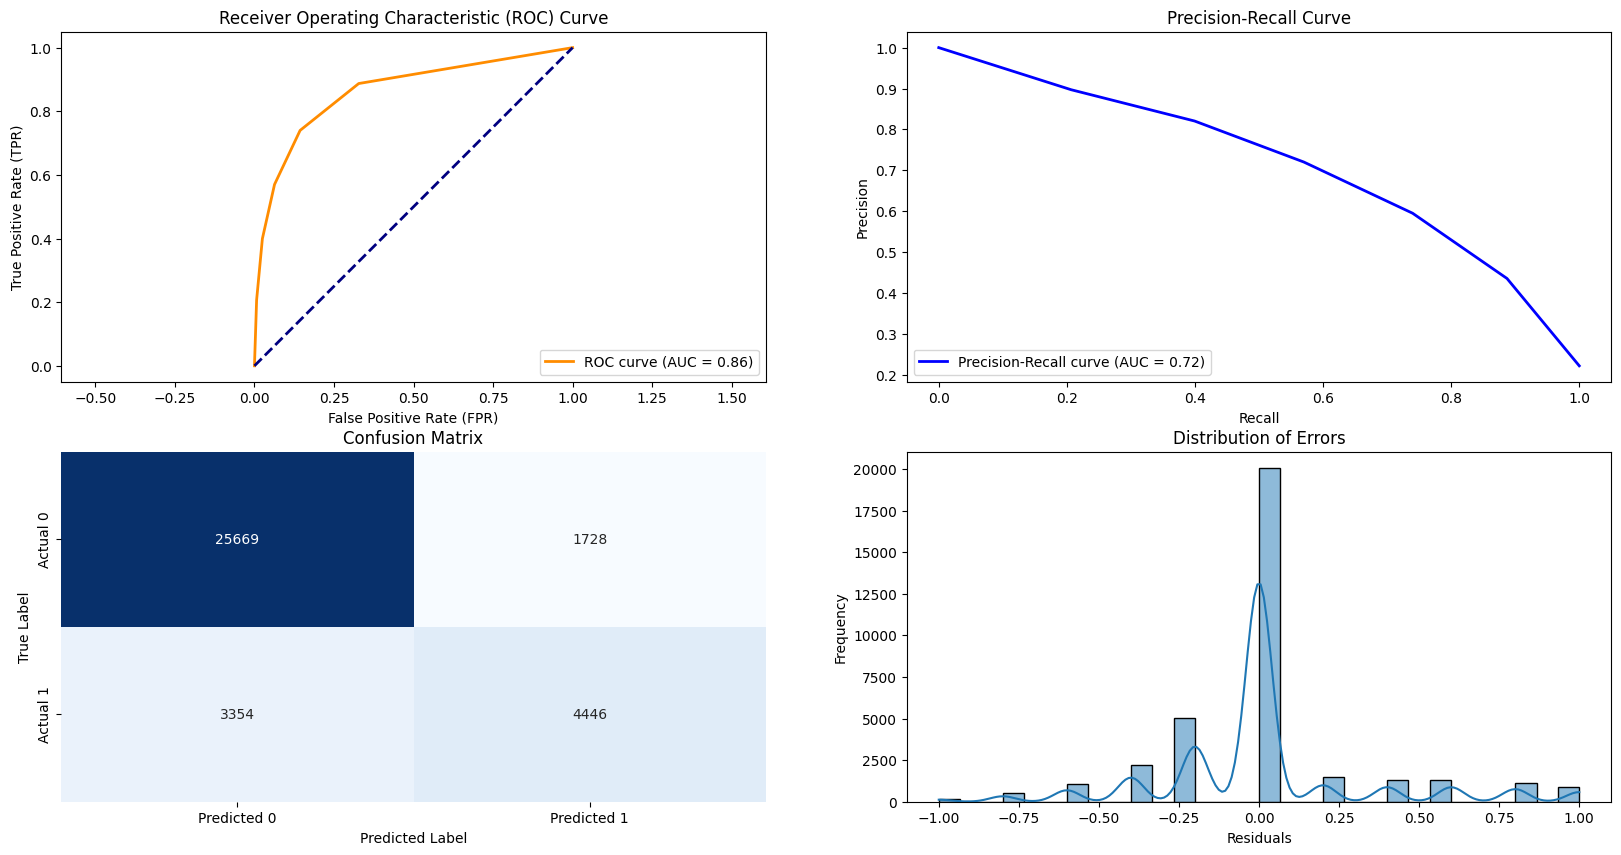

In [391]:
model = Model(KNeighborsClassifier(),'KNN No Resample', scaled=True, resample = None)
model.fit()
model.visualize_metrics()

In [392]:
metrics_KNN_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_KNN_no_resample.to_frame().T])
print(metrics_KNN_no_resample)

Accuracy                                 0.855613
Precision                                0.720117
Recall                                       0.57
F1-Score                                 0.636325
ROC AUC                                  0.861607
Confusion Matrix    [[25669, 1728], [3354, 4446]]
PR AUC                                   0.656541
Name                              KNN No Resample
dtype: object


### SMOTE

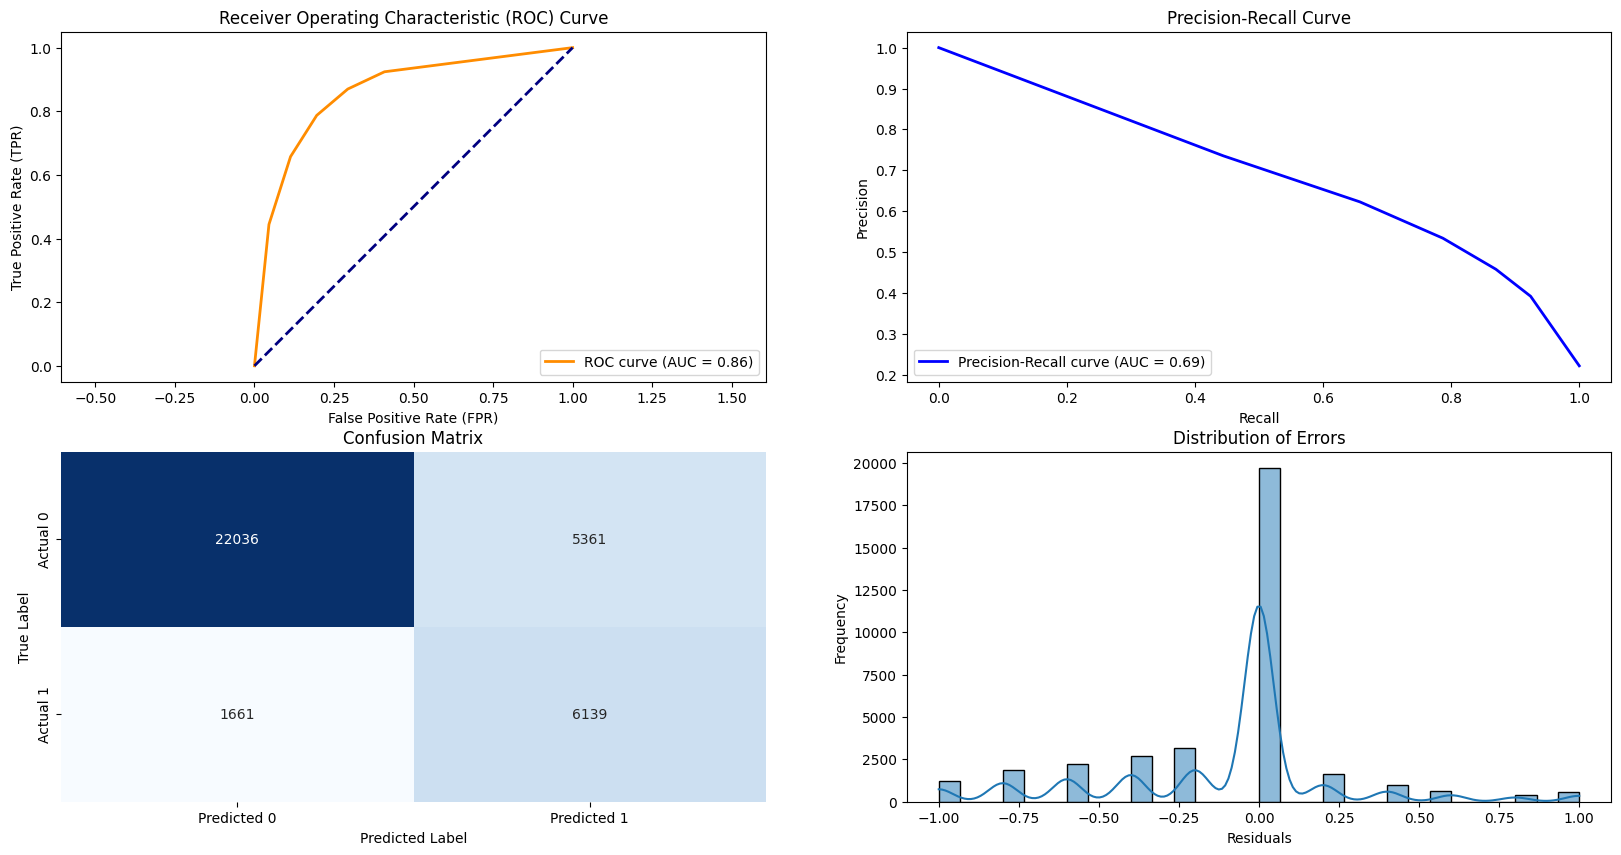

In [393]:
model = Model(KNeighborsClassifier(),'KNN SMOTE', scaled=True, resample = 'smote')
model.fit()
model.visualize_metrics()

In [394]:
metrics_KNN_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_KNN_smote.to_frame().T])
print(metrics_KNN_smote)

Accuracy                                 0.800494
Precision                                0.533826
Recall                                   0.787051
F1-Score                                 0.636166
ROC AUC                                  0.860175
Confusion Matrix    [[22036, 5361], [1661, 6139]]
PR AUC                                    0.60457
Name                                    KNN SMOTE
dtype: object


### Undersample

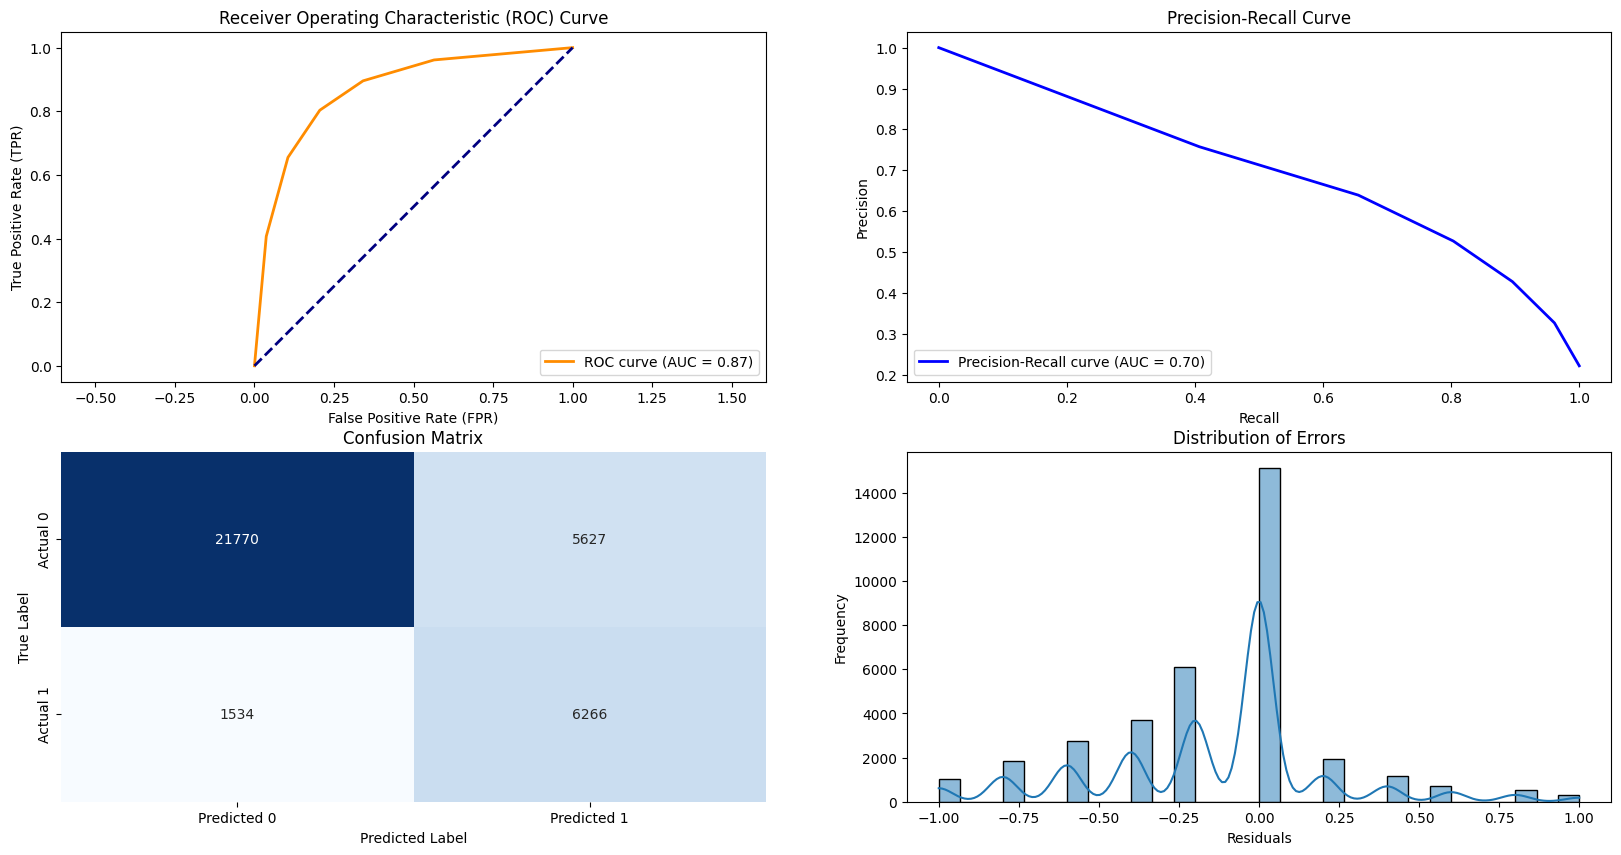

In [395]:
model = Model(KNeighborsClassifier(),'KNN Undersample', scaled=True, resample = 'under')
model.fit()
model.visualize_metrics()

In [396]:
metrics_KNN_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_KNN_under.to_frame().T])
print(metrics_KNN_under)

Accuracy                                 0.796545
Precision                                0.526865
Recall                                   0.803333
F1-Score                                 0.636368
ROC AUC                                  0.866511
Confusion Matrix    [[21770, 5627], [1534, 6266]]
PR AUC                                   0.614456
Name                              KNN Undersample
dtype: object


## XGBoost

### No Resample

In [397]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],  # Numero di alberi
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Tasso di apprendimento
    'max_depth': [3, 5, 7, 9],  # Profondità massima degli alberi
    'subsample': [0.6, 0.8, 1.0],  # Campione di dati utilizzato per ogni albero
    'colsample_bytree': [0.6, 0.8, 1.0],  # Percentuale di caratteristiche usate per albero
    'gamma': [0, 0.1, 0.2, 0.3],  # Complessità minima di split
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.01, 0.1, 1]  # L2 regularization
}

# Configura il modello
xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

# Configura RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Numero di combinazioni casuali da testare
    scoring='roc_auc',  # Usa ROC AUC per la valutazione
    cv=4,  # 3-fold cross validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Usa tutti i processori disponibili
)
# Fitta il modello
random_search.fit(X_train_scaled, y_train)
best_xgb_model = random_search.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


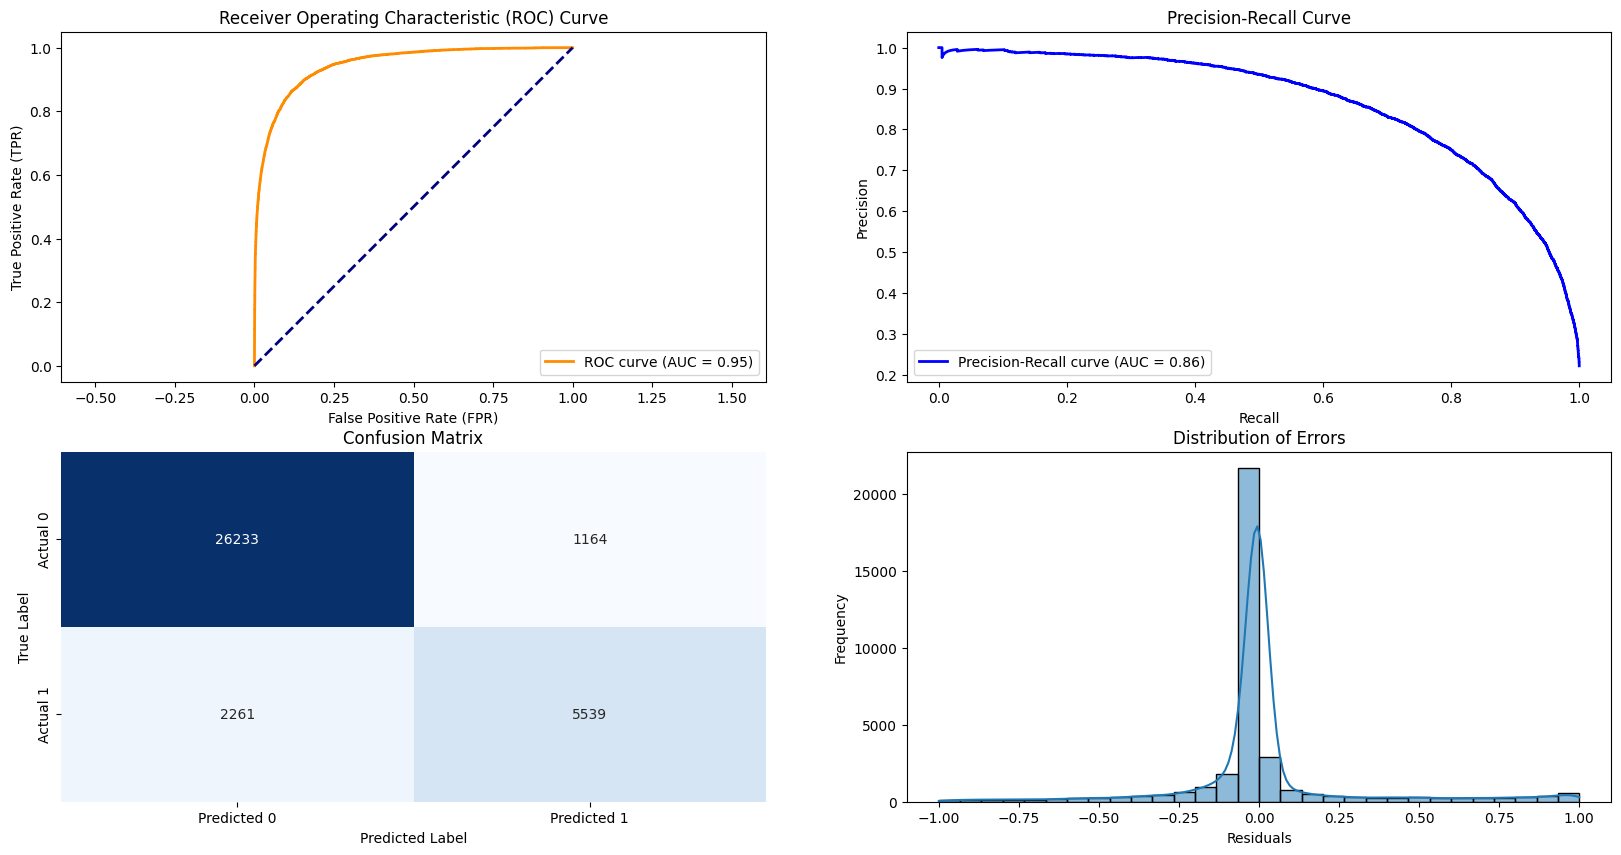

In [398]:
model = Model(best_xgb_model, name='XGB No Resample',
               scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [399]:
metrics_XG_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_XG_no_resample.to_frame().T])
print(metrics_XG_no_resample)

Accuracy                                 0.902691
Precision                                0.826346
Recall                                   0.710128
F1-Score                                 0.763842
ROC AUC                                  0.945946
Confusion Matrix    [[26233, 1164], [2261, 5539]]
PR AUC                                   0.863305
Name                              XGB No Resample
dtype: object


### SMOTE

In [400]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],  # Numero di alberi
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Tasso di apprendimento
    'max_depth': [3, 5, 7, 9],  # Profondità massima degli alberi
    'subsample': [0.6, 0.8, 1.0],  # Campione di dati utilizzato per ogni albero
    'colsample_bytree': [0.6, 0.8, 1.0],  # Percentuale di caratteristiche usate per albero
    'gamma': [0, 0.1, 0.2, 0.3],  # Complessità minima di split
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.01, 0.1, 1]  # L2 regularization
}

# Configura il modello
xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

# Configura RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Numero di combinazioni casuali da testare
    scoring='roc_auc',  # Usa ROC AUC per la valutazione
    cv=4,  # 3-fold cross validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Usa tutti i processori disponibili
)
# Fitta il modello
random_search.fit(X_train_smote_scaled, y_train_smote)
best_xgb_model = random_search.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


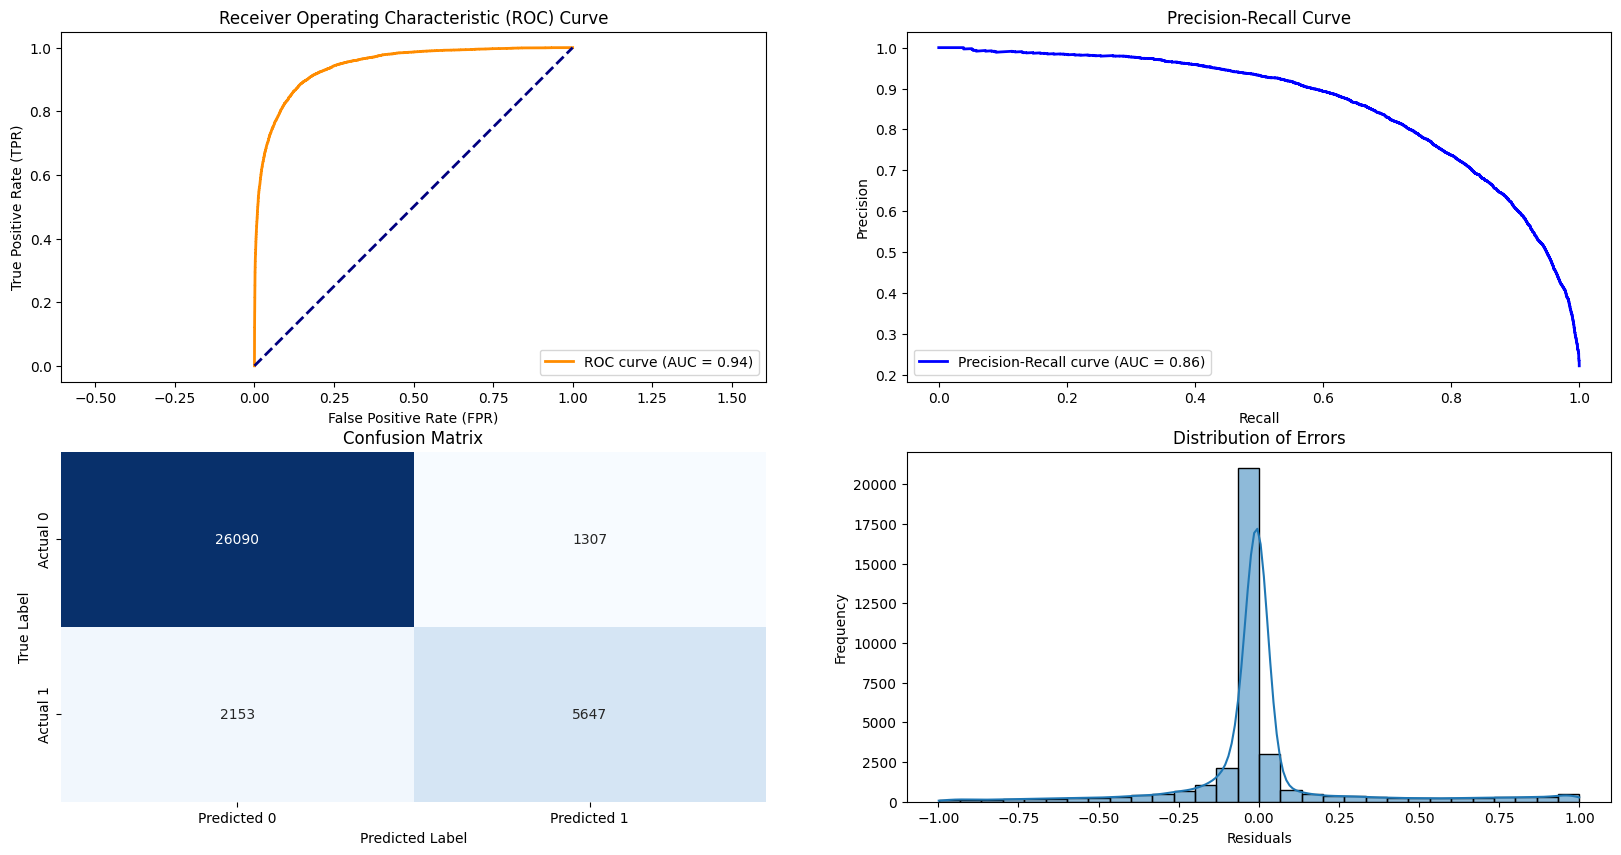

In [401]:
model = Model(best_xgb_model, name='XGB Smote',
               scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [402]:
metrics_XG_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_XG_smote.to_frame().T])
print(metrics_XG_smote)

Accuracy                                 0.901696
Precision                                0.812051
Recall                                   0.723974
F1-Score                                 0.765487
ROC AUC                                  0.943871
Confusion Matrix    [[26090, 1307], [2153, 5647]]
PR AUC                                   0.859764
Name                                    XGB Smote
dtype: object


### Undersample

In [403]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],  # Numero di alberi
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Tasso di apprendimento
    'max_depth': [3, 5, 7, 9],  # Profondità massima degli alberi
    'subsample': [0.6, 0.8, 1.0],  # Campione di dati utilizzato per ogni albero
    'colsample_bytree': [0.6, 0.8, 1.0],  # Percentuale di caratteristiche usate per albero
    'gamma': [0, 0.1, 0.2, 0.3],  # Complessità minima di split
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.01, 0.1, 1]  # L2 regularization
}

# Configura il modello
xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

# Configura RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Numero di combinazioni casuali da testare
    scoring='roc_auc',  # Usa ROC AUC per la valutazione
    cv=4,  # 3-fold cross validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Usa tutti i processori disponibili
)
# Fitta il modello
random_search.fit(X_train_under_scaled, y_train_under)
best_xgb_model = random_search.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


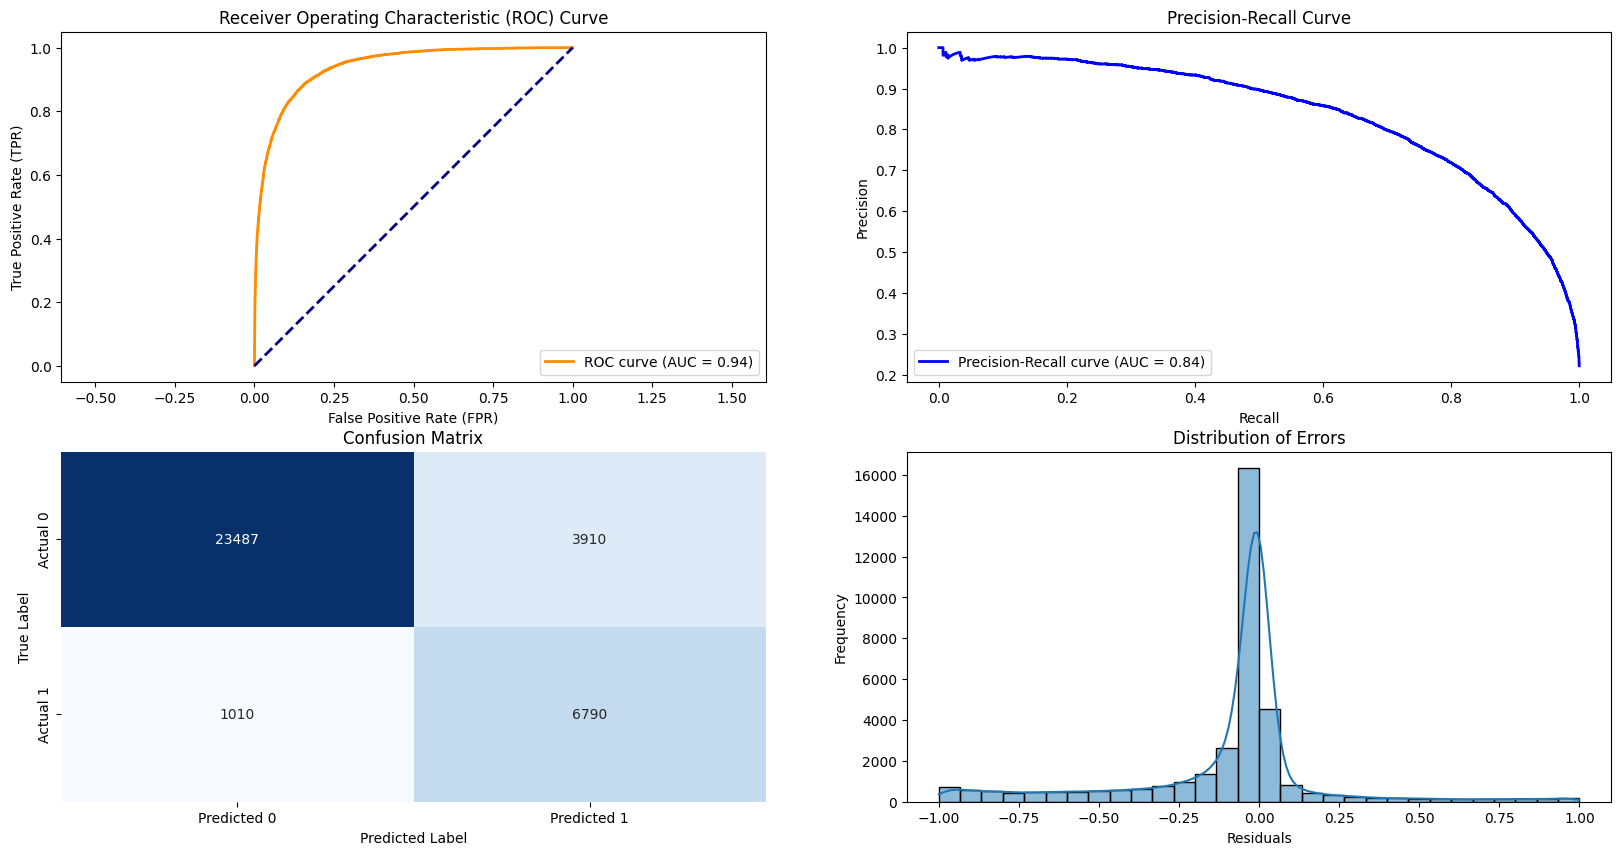

In [404]:
model = Model(best_xgb_model, name='XGB Undersample',
               scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [405]:
metrics_XG_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_XG_under.to_frame().T])
print(metrics_XG_under)

Accuracy                                 0.860215
Precision                                0.634579
Recall                                   0.870513
F1-Score                                 0.734054
ROC AUC                                  0.939591
Confusion Matrix    [[23487, 3910], [1010, 6790]]
PR AUC                                   0.837647
Name                              XGB Undersample
dtype: object


## Gradient Boosting

### No Resample

In [406]:
from scipy.stats import uniform

# Definizione dei parametri per la ricerca casuale
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': uniform(0.01, 0.3),  # Valori casuali tra 0.01 e 0.31
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf': [20, 50, 70],
    'max_features': ['sqrt', 'log2']
}

# Definizione del modello Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)

# RandomizedSearchCV con 10 iterazioni e 3 fold di cross-validation
random_search = RandomizedSearchCV(gb, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit del modello
random_search.fit(X_train_scaled, y_train)
best_gb_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=  14.5s
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=  14.6s
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=  14.7s
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time=  32.2s
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time=  31.8s
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time=  31.9s
[CV

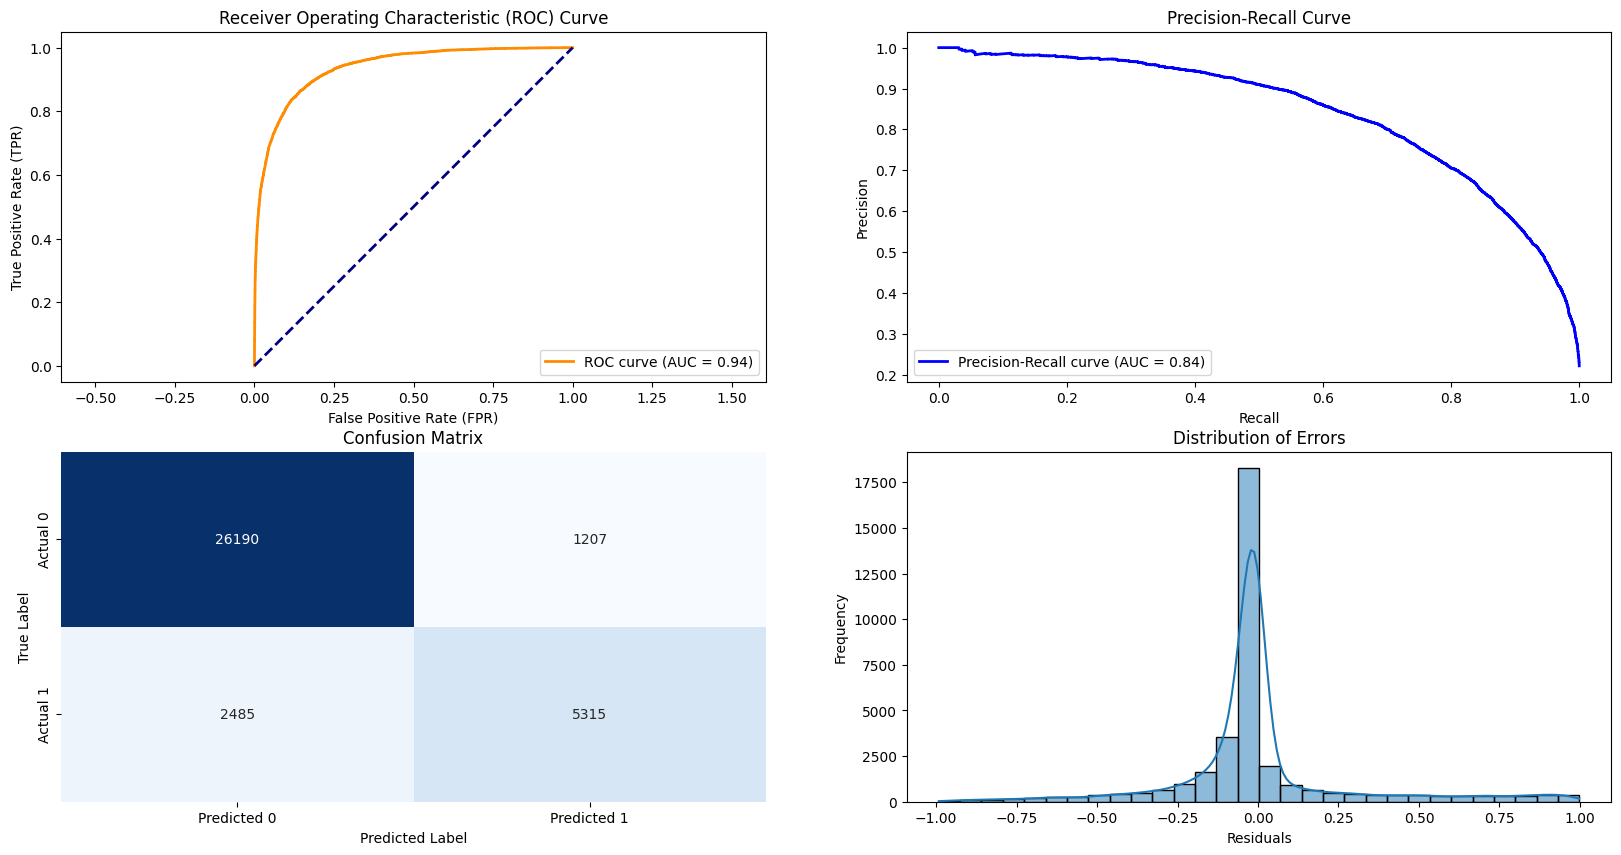

In [407]:
model = Model(best_gb_model, name='Gradient Boosting No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [408]:
metrics_GBC_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_GBC_no_resample.to_frame().T])
print(metrics_GBC_no_resample)

Accuracy                                 0.895105
Precision                                0.814934
Recall                                    0.68141
F1-Score                                 0.742215
ROC AUC                                  0.936371
Confusion Matrix    [[26190, 1207], [2485, 5315]]
PR AUC                                   0.840094
Name                Gradient Boosting No Resample
dtype: object


### SMOTE

In [409]:
# Definizione dei parametri per la ricerca casuale
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': uniform(0.01, 0.3),  # Valori casuali tra 0.01 e 0.31
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf': [20, 50, 70],
    'max_features': ['sqrt', 'log2']
}

# Definizione del modello Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)

# RandomizedSearchCV con 10 iterazioni e 3 fold di cross-validation
random_search = RandomizedSearchCV(gb, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit del modello
random_search.fit(X_train_smote_scaled, y_train_smote)
best_gb_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=  28.0s
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=  28.2s
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=  33.6s
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time= 1.2min
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time= 1.1min
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time= 1.1min
[CV] END learning_rate=0.07370173320348283, max_depth=3, max_fea

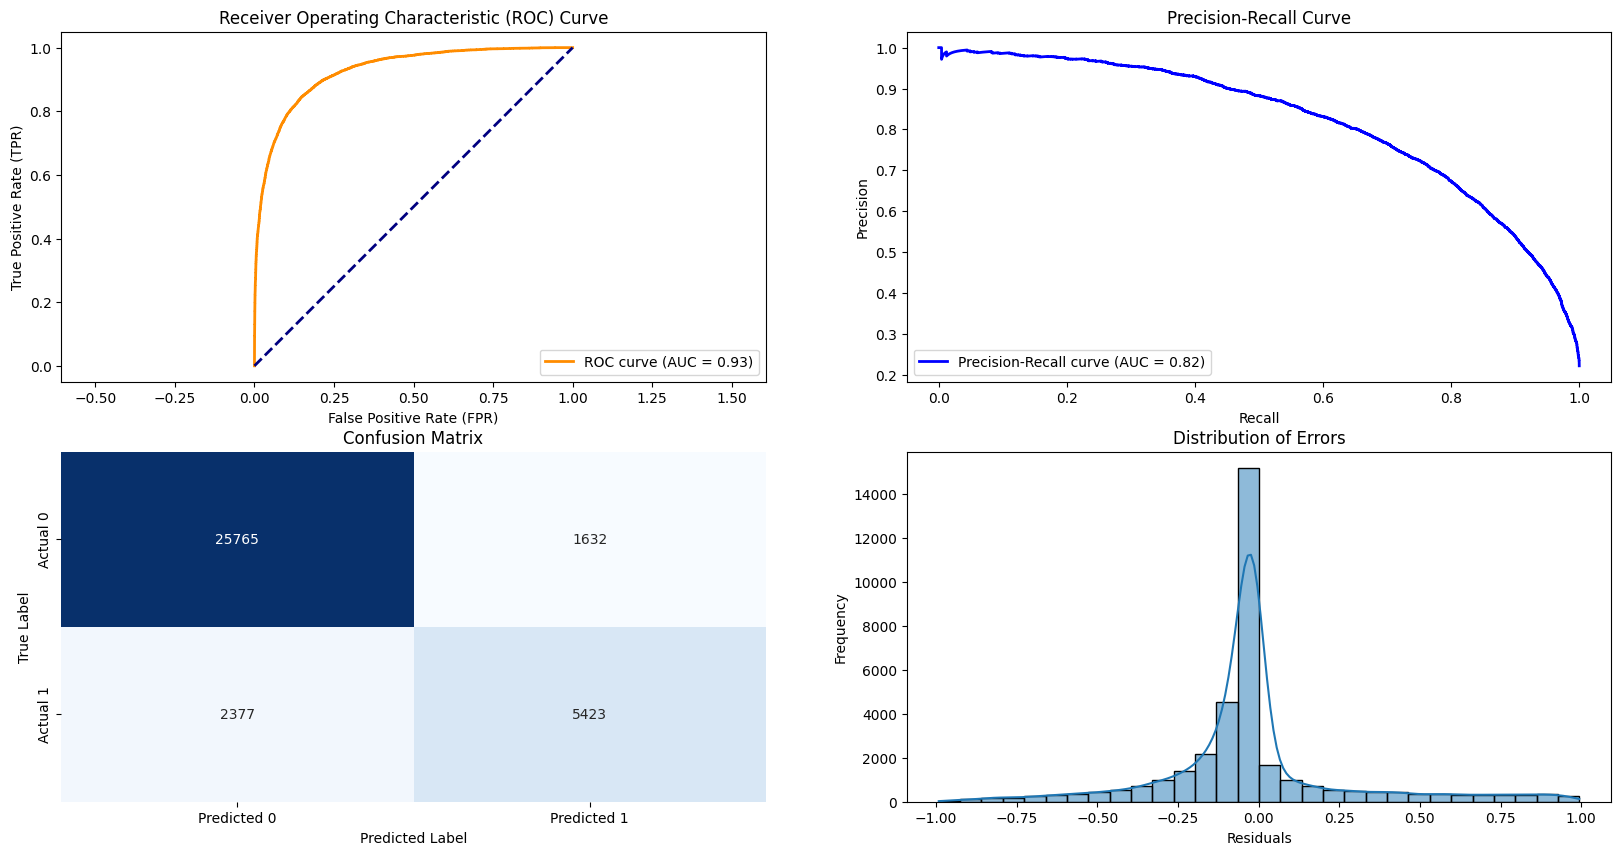

In [410]:
model = Model(best_gb_model, name='Gradient Boosting SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [411]:
metrics_GBC_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_GBC_smote.to_frame().T])
print(metrics_GBC_smote)

Accuracy                                 0.886098
Precision                                0.768675
Recall                                   0.695256
F1-Score                                 0.730125
ROC AUC                                  0.926566
Confusion Matrix    [[25765, 1632], [2377, 5423]]
PR AUC                                   0.819383
Name                      Gradient Boosting SMOTE
dtype: object


### Undersample

In [412]:
# Definizione dei parametri per la ricerca casuale
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': uniform(0.01, 0.3),  # Valori casuali tra 0.01 e 0.31
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf': [20, 50, 70],
    'max_features': ['sqrt', 'log2']
}

# Definizione del modello Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)

# RandomizedSearchCV con 10 iterazioni e 3 fold di cross-validation
random_search = RandomizedSearchCV(gb, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit del modello
random_search.fit(X_train_under_scaled, y_train_under)
best_gb_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=   8.3s
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=   8.2s
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=   8.2s
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time=  16.6s
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time=  16.3s
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time=  16.4s
[CV] END learning_rate=0.07370173320348283, max_depth=3, max_fea

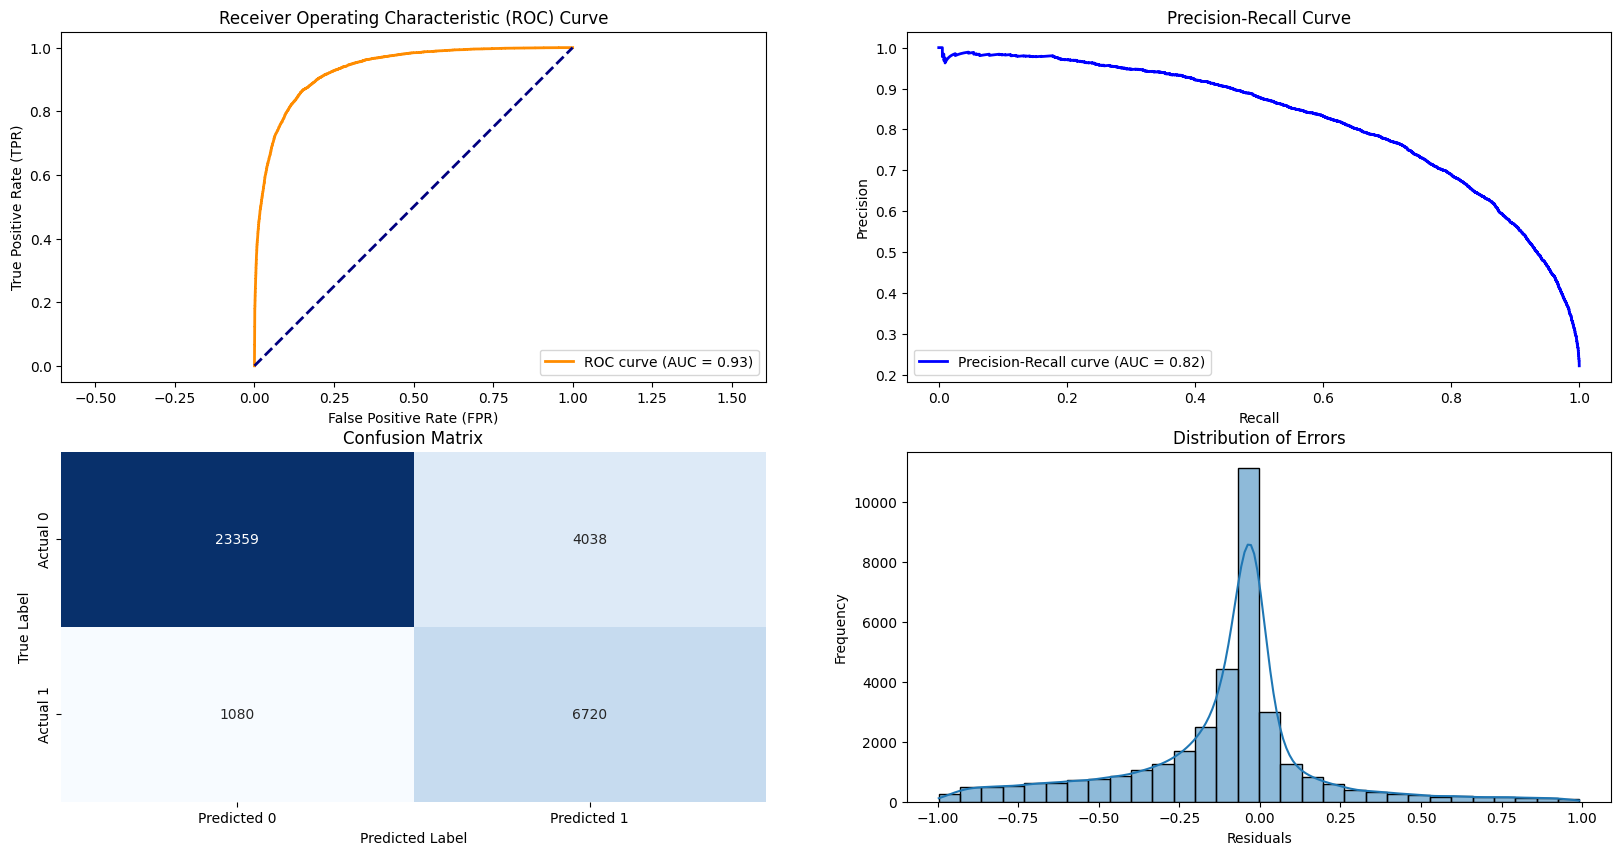

In [413]:
model = Model(best_gb_model, name='Gradient Boosting Undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [414]:
metrics_GBC_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_GBC_under.to_frame().T])
print(metrics_GBC_under)

Accuracy                                  0.85459
Precision                                0.624651
Recall                                   0.861538
F1-Score                                 0.724216
ROC AUC                                  0.932187
Confusion Matrix    [[23359, 4038], [1080, 6720]]
PR AUC                                   0.823452
Name                Gradient Boosting Undersample
dtype: object


## Random Forest

### No Resample

In [415]:
'''
# Definire l'intervallo di parametri da esplorare
param_dist = {
    'n_estimators': [100, 200, 300],  # Numero di alberi nella foresta
    'max_depth': [10, 20, 30, None],  # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10],  # Numero minimo di campioni per effettuare uno split
    'min_samples_leaf': [1, 2, 4],    # Numero minimo di campioni nelle foglie
    'bootstrap': [True, False]        # Se campionare con sostituzione o meno
}

# Inizializzare il modello Random Forest
rf_model = RandomForestClassifier()

# RandomizedSearchCV per esplorare casualmente i parametri
rf_random_search = RandomizedSearchCV(estimator=rf_model,
                                      param_distributions=param_dist,
                                      n_iter=50,    # Numero di iterazioni da fare
                                      cv=3,         # Numero di folds per cross-validation
                                      verbose=2,    # Per visualizzare il progresso
                                      random_state=42,  # Per riproducibilità
                                      n_jobs=-1)    # Utilizzo di tutti i core del processore

# Eseguire la ricerca
rf_random_search.fit(X_train_scaled, y_train)

# Miglior modello trovato
best_rf_model = rf_random_search.best_estimator_
'''

"\n# Definire l'intervallo di parametri da esplorare\nparam_dist = {\n    'n_estimators': [100, 200, 300],  # Numero di alberi nella foresta\n    'max_depth': [10, 20, 30, None],  # Profondità massima degli alberi\n    'min_samples_split': [2, 5, 10],  # Numero minimo di campioni per effettuare uno split\n    'min_samples_leaf': [1, 2, 4],    # Numero minimo di campioni nelle foglie\n    'bootstrap': [True, False]        # Se campionare con sostituzione o meno\n}\n\n# Inizializzare il modello Random Forest\nrf_model = RandomForestClassifier()\n\n# RandomizedSearchCV per esplorare casualmente i parametri\nrf_random_search = RandomizedSearchCV(estimator=rf_model,\n                                      param_distributions=param_dist,\n                                      n_iter=50,    # Numero di iterazioni da fare\n                                      cv=3,         # Numero di folds per cross-validation\n                                      verbose=2,    # Per visualizzare il progress

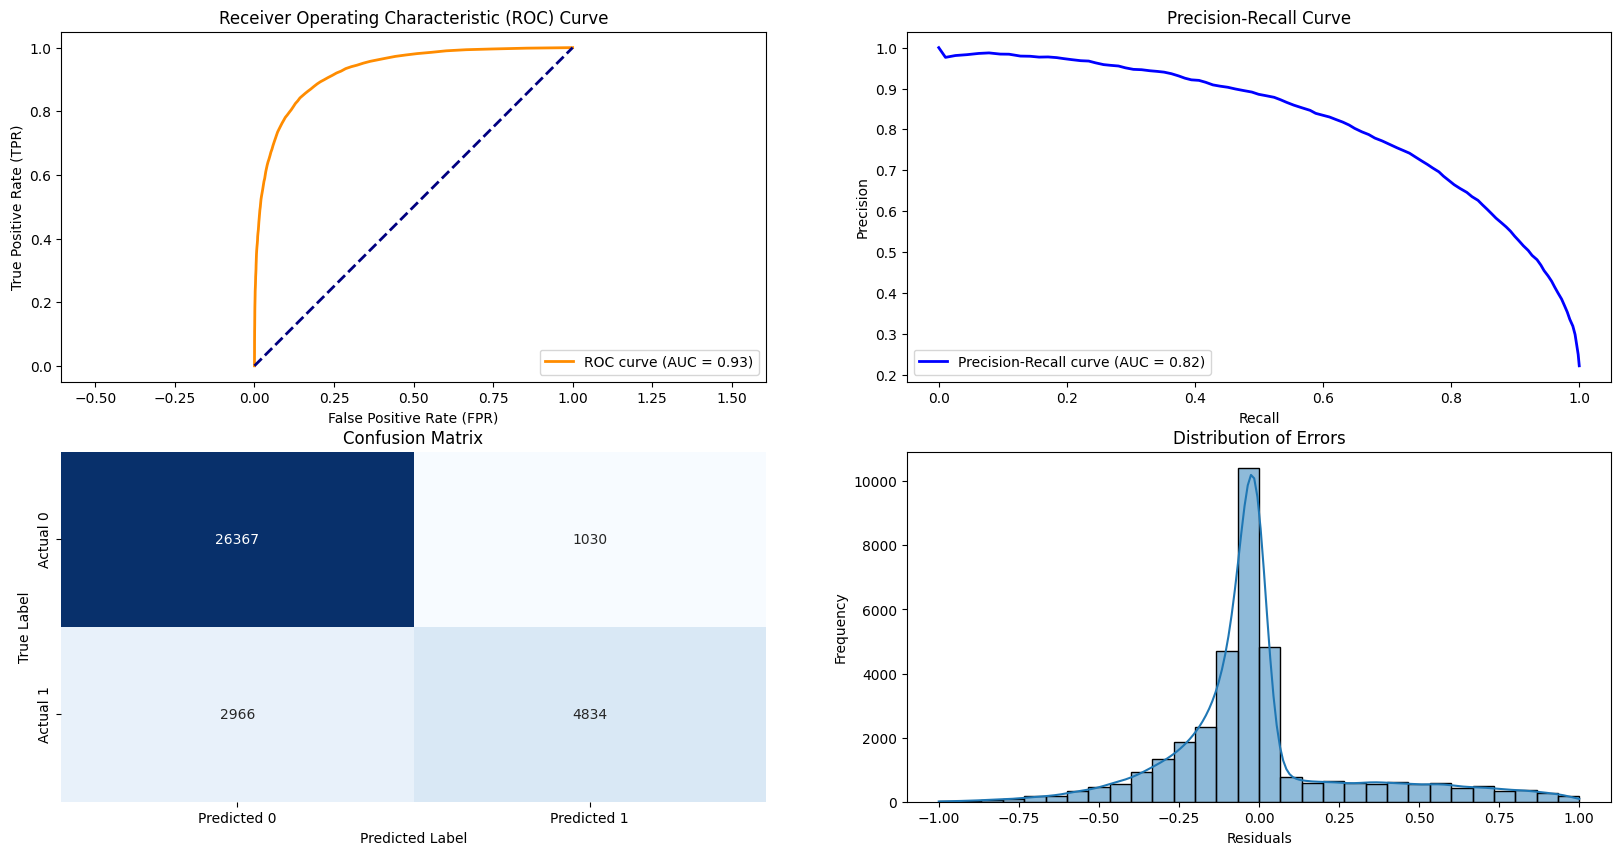

In [416]:
model = Model(RandomForestClassifier(), name='RF No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [417]:
metrics_RF_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_RF_no_resample.to_frame().T])
print(metrics_RF_no_resample)

Accuracy                                 0.886468
Precision                                0.824352
Recall                                   0.619744
F1-Score                                 0.707553
ROC AUC                                  0.927681
Confusion Matrix    [[26367, 1030], [2966, 4834]]
PR AUC                                    0.81629
Name                               RF No Resample
dtype: object


### SMOTE

In [418]:
model = Model(RandomForestClassifier(), name='RF SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [419]:
metrics_RF_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_RF_smote.to_frame().T])
print(metrics_RF_smote)

Accuracy                                 0.885047
Precision                                0.746714
Recall                                   0.728333
F1-Score                                 0.737409
ROC AUC                                  0.927348
Confusion Matrix    [[25470, 1927], [2119, 5681]]
PR AUC                                   0.815384
Name                                     RF SMOTE
dtype: object


### Undersample

In [420]:
model = Model(RandomForestClassifier(), name='RF Undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [421]:
metrics_RF_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_RF_under.to_frame().T])
print(metrics_RF_under)

Accuracy                                 0.842458
Precision                                0.602921
Recall                                   0.846795
F1-Score                                 0.704346
ROC AUC                                  0.922635
Confusion Matrix    [[23047, 4350], [1195, 6605]]
PR AUC                                   0.795551
Name                               RF Undersample
dtype: object


## CatBoost

### No Resample

In [422]:
model = cb.CatBoostClassifier()
grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [6, 8, 10]
}
grid_search = GridSearchCV(model, grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test), verbose=100)
best_model = grid_search.best_estimator_

0:	learn: 0.6840858	test: 0.6840921	best: 0.6840921 (0)	total: 119ms	remaining: 59.5s
0:	learn: 0.6109249	test: 0.6107249	best: 0.6107249 (0)	total: 100ms	remaining: 49.9s
0:	learn: 0.6842216	test: 0.6842474	best: 0.6842474 (0)	total: 190ms	remaining: 1m 34s
0:	learn: 0.6842421	test: 0.6842332	best: 0.6842332 (0)	total: 222ms	remaining: 1m 50s
100:	learn: 0.3742291	test: 0.3749555	best: 0.3749555 (100)	total: 10.2s	remaining: 40.5s
100:	learn: 0.3768875	test: 0.3765331	best: 0.3765331 (100)	total: 10.3s	remaining: 40.5s
100:	learn: 0.2927579	test: 0.2984198	best: 0.2984198 (100)	total: 10.5s	remaining: 41.4s
100:	learn: 0.3736098	test: 0.3747158	best: 0.3747158 (100)	total: 10.5s	remaining: 41.4s
200:	learn: 0.3351205	test: 0.3370122	best: 0.3370122 (200)	total: 17.8s	remaining: 26.4s
200:	learn: 0.2663694	test: 0.2812837	best: 0.2812837 (200)	total: 17.7s	remaining: 26.3s
200:	learn: 0.3380416	test: 0.3379996	best: 0.3379996 (200)	total: 17.7s	remaining: 26.3s
200:	learn: 0.3347344	te

In [423]:
model = Model(best_model, 
              name='CatBoost No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

0:	learn: 0.6093560	total: 111ms	remaining: 1m 50s
1:	learn: 0.5460507	total: 207ms	remaining: 1m 43s
2:	learn: 0.4955955	total: 256ms	remaining: 1m 25s
3:	learn: 0.4611444	total: 293ms	remaining: 1m 12s
4:	learn: 0.4352981	total: 324ms	remaining: 1m 4s
5:	learn: 0.4137541	total: 422ms	remaining: 1m 9s
6:	learn: 0.3962727	total: 522ms	remaining: 1m 14s
7:	learn: 0.3833516	total: 633ms	remaining: 1m 18s
8:	learn: 0.3730324	total: 680ms	remaining: 1m 14s
9:	learn: 0.3645556	total: 712ms	remaining: 1m 10s
10:	learn: 0.3577224	total: 743ms	remaining: 1m 6s
11:	learn: 0.3508124	total: 775ms	remaining: 1m 3s
12:	learn: 0.3455012	total: 810ms	remaining: 1m 1s
13:	learn: 0.3406784	total: 837ms	remaining: 58.9s
14:	learn: 0.3371268	total: 903ms	remaining: 59.3s
15:	learn: 0.3340424	total: 941ms	remaining: 57.9s
16:	learn: 0.3316372	total: 976ms	remaining: 56.4s
17:	learn: 0.3290862	total: 1.01s	remaining: 54.9s
18:	learn: 0.3270983	total: 1.04s	remaining: 53.8s
19:	learn: 0.3250355	total: 1.1s	

In [424]:
metrics_CB_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_CB_no_resample.to_frame().T])
print(metrics_CB_no_resample)

Accuracy                                 0.901895
Precision                                0.826204
Recall                                   0.705769
F1-Score                                 0.761253
ROC AUC                                  0.945209
Confusion Matrix    [[26239, 1158], [2295, 5505]]
PR AUC                                   0.859962
Name                         CatBoost No Resample
dtype: object


### SMOTE

Learning rate set to 0.091012
0:	learn: 0.6172185	total: 59.4ms	remaining: 59.3s
1:	learn: 0.5694716	total: 91.5ms	remaining: 45.7s
2:	learn: 0.5380705	total: 122ms	remaining: 40.6s
3:	learn: 0.5125400	total: 158ms	remaining: 39.4s
4:	learn: 0.4925284	total: 187ms	remaining: 37.3s
5:	learn: 0.4709423	total: 222ms	remaining: 36.9s
6:	learn: 0.4555821	total: 259ms	remaining: 36.8s
7:	learn: 0.4440090	total: 297ms	remaining: 36.8s
8:	learn: 0.4336080	total: 327ms	remaining: 36s
9:	learn: 0.4245721	total: 357ms	remaining: 35.3s
10:	learn: 0.4161650	total: 387ms	remaining: 34.8s
11:	learn: 0.4101282	total: 419ms	remaining: 34.5s
12:	learn: 0.4050757	total: 449ms	remaining: 34.1s
13:	learn: 0.3997364	total: 480ms	remaining: 33.8s
14:	learn: 0.3959126	total: 512ms	remaining: 33.6s
15:	learn: 0.3889215	total: 543ms	remaining: 33.4s
16:	learn: 0.3850321	total: 572ms	remaining: 33.1s
17:	learn: 0.3809928	total: 601ms	remaining: 32.8s
18:	learn: 0.3774159	total: 629ms	remaining: 32.5s
19:	learn: 

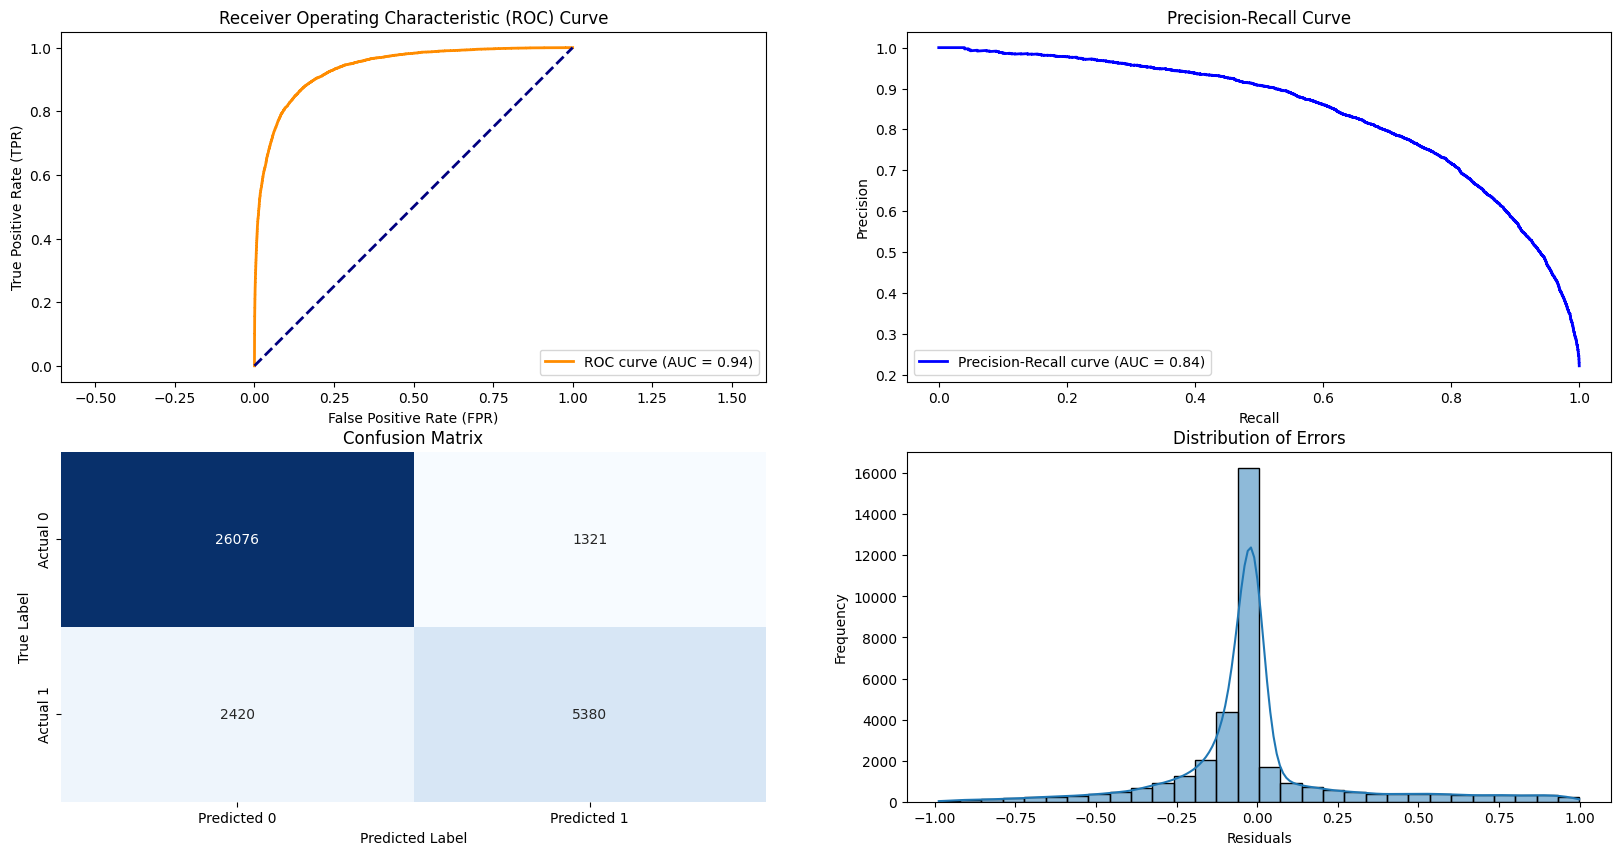

In [425]:
model = Model(cb.CatBoostClassifier(), 
              name='CatBoost SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [426]:
metrics_CB_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_CB_smote.to_frame().T])
print(metrics_CB_smote)

Accuracy                                 0.893713
Precision                                0.802865
Recall                                   0.689744
F1-Score                                 0.742018
ROC AUC                                  0.936214
Confusion Matrix    [[26076, 1321], [2420, 5380]]
PR AUC                                   0.839703
Name                               CatBoost SMOTE
dtype: object


### Undersample

Learning rate set to 0.053228
0:	learn: 0.6638688	total: 31ms	remaining: 31s
1:	learn: 0.6375843	total: 50.7ms	remaining: 25.3s
2:	learn: 0.6155869	total: 85.5ms	remaining: 28.4s
3:	learn: 0.5954070	total: 135ms	remaining: 33.5s
4:	learn: 0.5764304	total: 146ms	remaining: 29.1s
5:	learn: 0.5613789	total: 158ms	remaining: 26.2s
6:	learn: 0.5477545	total: 176ms	remaining: 24.9s
7:	learn: 0.5351237	total: 192ms	remaining: 23.8s
8:	learn: 0.5235770	total: 206ms	remaining: 22.6s
9:	learn: 0.5141911	total: 219ms	remaining: 21.7s
10:	learn: 0.5057189	total: 235ms	remaining: 21.1s
11:	learn: 0.4979154	total: 246ms	remaining: 20.3s
12:	learn: 0.4915231	total: 259ms	remaining: 19.7s
13:	learn: 0.4853283	total: 276ms	remaining: 19.4s
14:	learn: 0.4795564	total: 291ms	remaining: 19.1s
15:	learn: 0.4742262	total: 305ms	remaining: 18.8s
16:	learn: 0.4697037	total: 317ms	remaining: 18.3s
17:	learn: 0.4653226	total: 336ms	remaining: 18.3s
18:	learn: 0.4616435	total: 350ms	remaining: 18.1s
19:	learn: 0

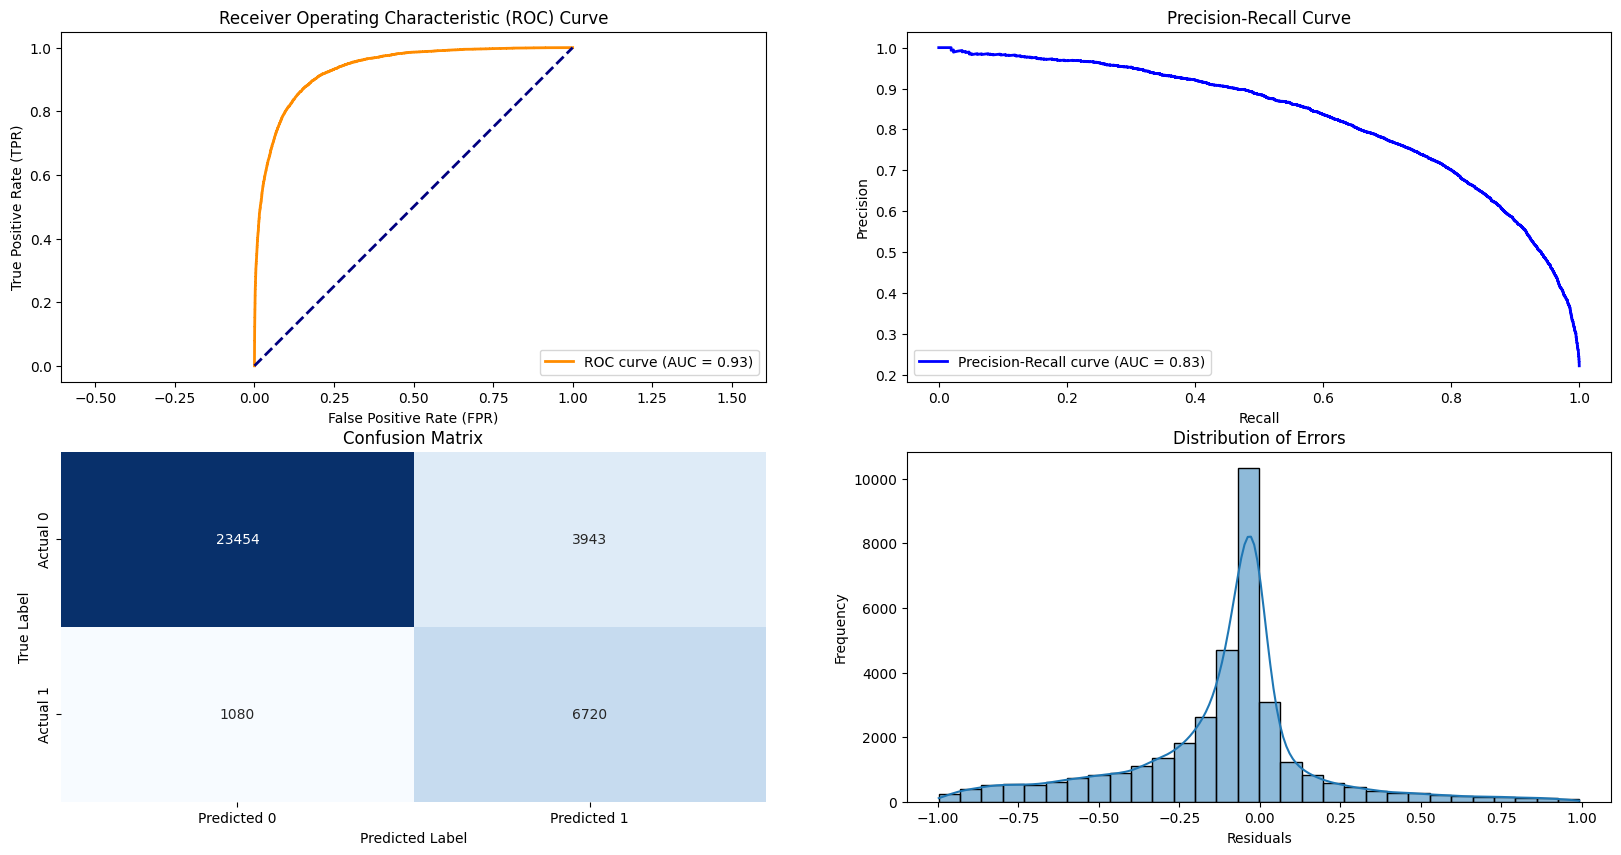

In [427]:
model = Model(cb.CatBoostClassifier(), 
              name='CatBoost Undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [428]:
metrics_CB_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_CB_under.to_frame().T])
print(metrics_CB_under)

Accuracy                                 0.857289
Precision                                0.630217
Recall                                   0.861538
F1-Score                                 0.727942
ROC AUC                                  0.934537
Confusion Matrix    [[23454, 3943], [1080, 6720]]
PR AUC                                   0.827425
Name                         CatBoost Undersample
dtype: object


## Neural Network

### No Resample

In [429]:
model = Sequential([
    Input(shape=[X_train.shape[1]]),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(96, activation='relu'),
    Dense(96, activation='relu'),
    Dense(96, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'), 
    Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Model training
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    batch_size=100,
    epochs=100,
    shuffle = True,
    callbacks=[early_stopping]
)

Epoch 1/100
1056/1056 [==============================] - 8s 6ms/step - loss: 0.3575 - binary_accuracy: 0.8455 - val_loss: 0.3329 - val_binary_accuracy: 0.8624
Epoch 2/100
1056/1056 [==============================] - 5s 5ms/step - loss: 0.3367 - binary_accuracy: 0.8560 - val_loss: 0.3273 - val_binary_accuracy: 0.8651
Epoch 3/100
1056/1056 [==============================] - 6s 5ms/step - loss: 0.3306 - binary_accuracy: 0.8592 - val_loss: 0.3154 - val_binary_accuracy: 0.8664
Epoch 4/100
1056/1056 [==============================] - 6s 5ms/step - loss: 0.3249 - binary_accuracy: 0.8614 - val_loss: 0.3066 - val_binary_accuracy: 0.8723
Epoch 5/100
1056/1056 [==============================] - 6s 5ms/step - loss: 0.3164 - binary_accuracy: 0.8663 - val_loss: 0.2931 - val_binary_accuracy: 0.8823
Epoch 6/100
1056/1056 [==============================] - 6s 5ms/step - loss: 0.3032 - binary_accuracy: 0.8731 - val_loss: 0.2730 - val_binary_accuracy: 0.8911
Epoch 7/100
1056/1056 [=======================

Best Validation Loss: 0.2274
Best Validation Accuracy: 0.9072


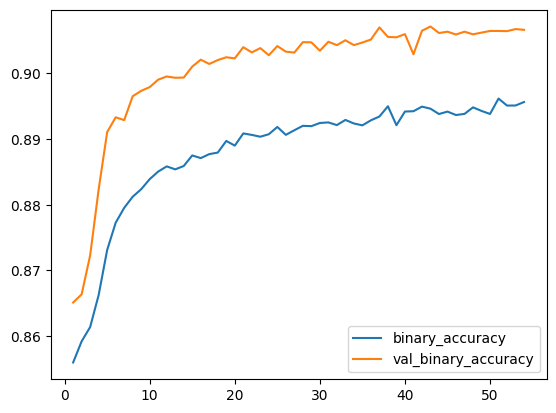

In [430]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [431]:
y_pred_prob_test = model.predict(X_test_scaled)
y_pred_test = np.where(y_pred_prob_test.squeeze() < 0.5, 0, 1)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
print(acc_test)

1100/1100 [==============================] - 2s 2ms/step
0.9061567747251186


In [432]:
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
pr_auc = metrics.average_precision_score(y_test, y_pred_prob_test)
metrics_TF = pd.Series({
'Accuracy': accuracy,
'Precision': precision,
'Recall': recall,
'F1-Score': f1,
'ROC AUC': roc_auc,
'PR AUC': pr_auc,
'Confusion Matrix': conf_mat,
'Name':'NN No Resample'
})
print(metrics_TF)
models_df = pd.concat([models_df, metrics_TF.to_frame().T])

Accuracy                                 0.906157
Precision                                0.822736
Recall                                   0.734872
F1-Score                                 0.776326
ROC AUC                                  0.951062
PR AUC                                   0.872792
Confusion Matrix    [[26162, 1235], [2068, 5732]]
Name                               NN No Resample
dtype: object


## SMOTE

In [433]:
model = Sequential([
    Input(shape=[X_train.shape[1]]),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(96, activation='relu'),
    Dense(96, activation='relu'),
    Dense(96, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'), 
    Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Model training
history = model.fit(
    X_train_smote_scaled, y_train_smote,
    validation_data=(X_test_smote_scaled, y_test),
    batch_size=1024,
    epochs=100,
    shuffle = True,
    callbacks=[early_stopping]
)

Epoch 1/100
161/161 [==============================] - 6s 24ms/step - loss: 0.4478 - binary_accuracy: 0.7877 - val_loss: 0.4071 - val_binary_accuracy: 0.8129
Epoch 2/100
161/161 [==============================] - 3s 21ms/step - loss: 0.3927 - binary_accuracy: 0.8247 - val_loss: 0.3938 - val_binary_accuracy: 0.8276
Epoch 3/100
161/161 [==============================] - 3s 22ms/step - loss: 0.3716 - binary_accuracy: 0.8355 - val_loss: 0.3789 - val_binary_accuracy: 0.8396
Epoch 4/100
161/161 [==============================] - 3s 21ms/step - loss: 0.3498 - binary_accuracy: 0.8461 - val_loss: 0.3648 - val_binary_accuracy: 0.8341
Epoch 5/100
161/161 [==============================] - 3s 21ms/step - loss: 0.3230 - binary_accuracy: 0.8597 - val_loss: 0.3277 - val_binary_accuracy: 0.8504
Epoch 6/100
161/161 [==============================] - 3s 22ms/step - loss: 0.3005 - binary_accuracy: 0.8705 - val_loss: 0.3689 - val_binary_accuracy: 0.8378
Epoch 7/100
161/161 [==============================]

Best Validation Loss: 0.2662
Best Validation Accuracy: 0.8814


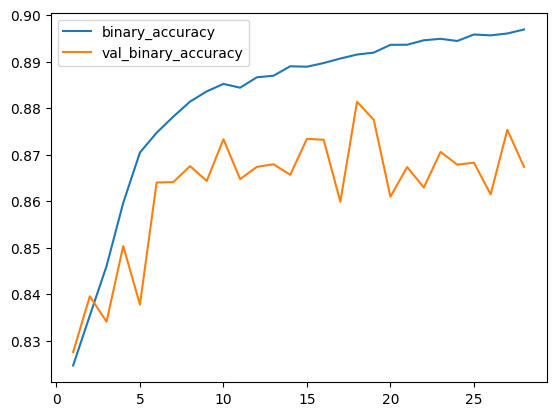

In [434]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [435]:
y_pred_prob_test = model.predict(X_test_smote_scaled)
y_pred_test = np.where(y_pred_prob_test.squeeze() < 0.5, 0, 1)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
print(acc_test)

1100/1100 [==============================] - 2s 2ms/step
0.8813535244481063


In [436]:
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
pr_auc = metrics.average_precision_score(y_test, y_pred_prob_test)
metrics_TF = pd.Series({
'Accuracy': accuracy,
'Precision': precision,
'Recall': recall,
'F1-Score': f1,
'ROC AUC': roc_auc,
'PR AUC': pr_auc,
'Confusion Matrix': conf_mat,
'Name':'NN Smote'
})
print(metrics_TF)
models_df_smote = pd.concat([models_df_smote, metrics_TF.to_frame().T])

Accuracy                                 0.881354
Precision                                0.683997
Recall                                    0.86359
F1-Score                                 0.763373
ROC AUC                                  0.951126
PR AUC                                   0.871712
Confusion Matrix    [[24285, 3112], [1064, 6736]]
Name                                     NN Smote
dtype: object


## Undersample

In [437]:
model = Sequential([
    Input(shape=[X_train.shape[1]]),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'), 
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Model training
history = model.fit(
    X_train_under_scaled, y_train_under,
    validation_data=(X_test_under_scaled, y_test),
    batch_size=40,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
1171/1171 [==============================] - 6s 4ms/step - loss: 0.4319 - binary_accuracy: 0.7999 - val_loss: 0.3733 - val_binary_accuracy: 0.8258
Epoch 2/100
1171/1171 [==============================] - 4s 4ms/step - loss: 0.4071 - binary_accuracy: 0.8148 - val_loss: 0.4269 - val_binary_accuracy: 0.7938
Epoch 3/100
1171/1171 [==============================] - 5s 5ms/step - loss: 0.3856 - binary_accuracy: 0.8291 - val_loss: 0.3548 - val_binary_accuracy: 0.8379
Epoch 4/100
1171/1171 [==============================] - 4s 4ms/step - loss: 0.3658 - binary_accuracy: 0.8401 - val_loss: 0.3236 - val_binary_accuracy: 0.8566
Epoch 5/100
1171/1171 [==============================] - 4s 4ms/step - loss: 0.3536 - binary_accuracy: 0.8453 - val_loss: 0.2983 - val_binary_accuracy: 0.8703
Epoch 6/100
1171/1171 [==============================] - 4s 4ms/step - loss: 0.3445 - binary_accuracy: 0.8494 - val_loss: 0.3247 - val_binary_accuracy: 0.8544
Epoch 7/100
1171/1171 [=======================

Best Validation Loss: 0.2498
Best Validation Accuracy: 0.8880


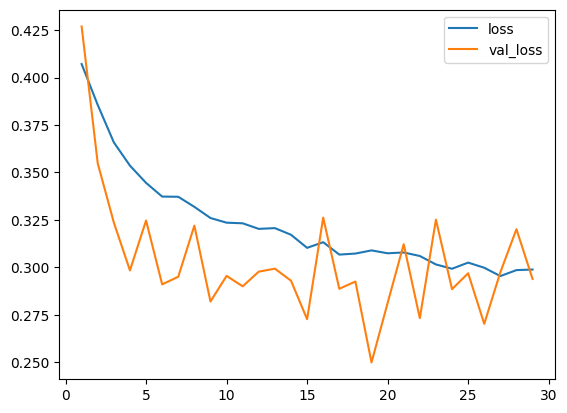

In [438]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [439]:
y_pred_prob_test = model.predict(X_test_under_scaled)
y_pred_test = np.where(y_pred_prob_test.squeeze() < 0.5, 0, 1)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
print(acc_test)

1100/1100 [==============================] - 2s 1ms/step
0.8880302298491348


In [440]:
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
pr_auc = metrics.average_precision_score(y_test, y_pred_prob_test)
metrics_TF = pd.Series({
'Accuracy': accuracy,
'Precision': precision,
'Recall': recall,
'F1-Score': f1,
'ROC AUC': roc_auc,
'PR AUC': pr_auc,
'Confusion Matrix': conf_mat,
'Name':'NN Undersample'
})
print(metrics_TF)
models_df_under = pd.concat([models_df_under, metrics_TF.to_frame().T])

Accuracy                                  0.88803
Precision                                 0.71215
Recall                                   0.830385
F1-Score                                 0.766736
ROC AUC                                   0.94843
PR AUC                                   0.862111
Confusion Matrix    [[24779, 2618], [1323, 6477]]
Name                               NN Undersample
dtype: object


# Conclusion
Now for each type of work (No Resample, SMOTE and Undersample) and for each metric we find the best method

## No Resample

In [441]:
models_df

Name  Accuracy Precision    Recall  F1-Score  \
0                  LDA No Resample    0.8578  0.719906  0.586538  0.646415   
0  Logistic Regression No Resample  0.859221  0.738634  0.564487  0.639924   
0                   DT No Resample  0.857971  0.729477  0.570769  0.640437   
0                  KNN No Resample  0.855613  0.720117      0.57  0.636325   
0                  XGB No Resample  0.902691  0.826346  0.710128  0.763842   
0    Gradient Boosting No Resample  0.895105  0.814934   0.68141  0.742215   
0                   RF No Resample  0.886468  0.824352  0.619744  0.707553   
0             CatBoost No Resample  0.901895  0.826204  0.705769  0.761253   
0                   NN No Resample  0.906157  0.822736  0.734872  0.776326   

    ROC AUC               Confusion Matrix    PR AUC  
0  0.888577  [[25617, 1780], [3225, 4575]]  0.727093  
0  0.889739  [[25839, 1558], [3397, 4403]]  0.729967  
0   0.88525  [[25746, 1651], [3348, 4452]]  0.726767  
0  0.861607  [[25669, 1728], [3354, 4446]]  0.656541  
0  0.945946  [[26233, 1164], [2261, 5539]]  0.863305  
0  0.936371  [[26190, 1207], [2485, 5315]]  0.840094  
0  0.927681  [[26367, 1030], [2966, 4834]]   0.81629  
0  0.945209  [[26239, 1158], [2295, 5505]]  0.859962  
0  0.951062  [[26162, 1235], [2068, 5732]]  0.872792

In [442]:
models_df.index = models_df.Name
models_df = models_df.drop('Name',axis=1)

In [443]:
df = models_df[[x for x in models_df.columns if x != 'Confusion Matrix']]
df.plot.bar(figsize=(20,10))

<Axes: xlabel='Name'>

In [444]:
for col in models_df.columns:
    if col != 'Confusion Matrix':
        print(models_df.sort_values(by=col, ascending=False)[col].head(1))

Name
NN No Resample    0.906157
Name: Accuracy, dtype: object
Name
XGB No Resample    0.826346
Name: Precision, dtype: object
Name
NN No Resample    0.734872
Name: Recall, dtype: object
Name
NN No Resample    0.776326
Name: F1-Score, dtype: object
Name
NN No Resample    0.951062
Name: ROC AUC, dtype: object
Name
NN No Resample    0.872792
Name: PR AUC, dtype: object


In [465]:
best_values_no_resample = pd.DataFrame(columns=['Metric', 'Best Value', 'Method'])

for col in models_df.columns:
    if col != 'Confusion Matrix':
        best_value_row = models_df.sort_values(by=col, ascending=False).head(1)
        best_value = best_value_row[col].values[0]
        method_name = best_value_row.index[0]  # Il nome del metodo dall'indice della riga
        new_row = pd.DataFrame({'Metric': [col], 'Best Value': [best_value], 'Method': [method_name]})
        best_values_no_resample = pd.concat([best_values_no_resample, new_row], ignore_index=True)

pd.DataFrame(best_values_no_resample)

Metric  Best Value           Method
0   Accuracy    0.906157   NN No Resample
1  Precision    0.826346  XGB No Resample
2     Recall    0.734872   NN No Resample
3   F1-Score    0.776326   NN No Resample
4    ROC AUC    0.951062   NN No Resample
5     PR AUC    0.872792   NN No Resample

## SMOTE

In [446]:
models_df_smote

Name  Accuracy Precision    Recall  F1-Score  \
0                  LDA SMOTE  0.815638  0.559241  0.793333   0.65603   
0  Logistic Regression Smote   0.81166  0.551718  0.800769  0.653313   
0                   DT Smote  0.830952  0.599957  0.711795  0.651108   
0                  KNN SMOTE  0.800494  0.533826  0.787051  0.636166   
0                  XGB Smote  0.901696  0.812051  0.723974  0.765487   
0    Gradient Boosting SMOTE  0.886098  0.768675  0.695256  0.730125   
0                   RF SMOTE  0.885047  0.746714  0.728333  0.737409   
0             CatBoost SMOTE  0.893713  0.802865  0.689744  0.742018   
0                   NN Smote  0.881354  0.683997   0.86359  0.763373   

    ROC AUC               Confusion Matrix    PR AUC  
0   0.88886  [[22520, 4877], [1612, 6188]]  0.726089  
0  0.889469  [[22322, 5075], [1554, 6246]]  0.726918  
0  0.826855  [[23695, 3702], [2248, 5552]]  0.581907  
0  0.860175  [[22036, 5361], [1661, 6139]]   0.60457  
0  0.943871  [[26090, 1307], [2153, 5647]]  0.859764  
0  0.926566  [[25765, 1632], [2377, 5423]]  0.819383  
0  0.927348  [[25470, 1927], [2119, 5681]]  0.815384  
0  0.936214  [[26076, 1321], [2420, 5380]]  0.839703  
0  0.951126  [[24285, 3112], [1064, 6736]]  0.871712

In [447]:
models_df_smote.index = models_df_smote.Name
models_df_smote = models_df_smote.drop('Name',axis=1)

In [448]:
df_smote = models_df_smote[[x for x in models_df_smote.columns if x != 'Confusion Matrix']]
df_smote.plot.bar(figsize=(20,10))

<Axes: xlabel='Name'>

In [449]:
for col in models_df_smote.columns:
    if col != 'Confusion Matrix':
        print(models_df_smote.sort_values(by=col, ascending=False)[col].head(1))

Name
XGB Smote    0.901696
Name: Accuracy, dtype: object
Name
XGB Smote    0.812051
Name: Precision, dtype: object
Name
NN Smote    0.86359
Name: Recall, dtype: object
Name
XGB Smote    0.765487
Name: F1-Score, dtype: object
Name
NN Smote    0.951126
Name: ROC AUC, dtype: object
Name
NN Smote    0.871712
Name: PR AUC, dtype: object


In [466]:
best_values_smote = pd.DataFrame(columns=['Metric', 'Best Value', 'Method'])

for col in models_df_smote.columns:
    if col != 'Confusion Matrix':
        best_value_row = models_df_smote.sort_values(by=col, ascending=False).head(1)
        best_value = best_value_row[col].values[0]
        method_name = best_value_row.index[0]  # Il nome del metodo dall'indice della riga
        new_row = pd.DataFrame({'Metric': [col], 'Best Value': [best_value], 'Method': [method_name]})
        best_values_smote = pd.concat([best_values_smote, new_row], ignore_index=True)

pd.DataFrame(best_values_smote)

Metric  Best Value     Method
0   Accuracy    0.901696  XGB Smote
1  Precision    0.812051  XGB Smote
2     Recall    0.863590   NN Smote
3   F1-Score    0.765487  XGB Smote
4    ROC AUC    0.951126   NN Smote
5     PR AUC    0.871712   NN Smote

## Undersample

In [451]:
models_df_under

Name  Accuracy Precision    Recall  F1-Score  \
0                  LDA undersample  0.815354  0.558757  0.793077  0.655609   
0  Logistic Regression Undersample   0.81149  0.551399  0.801154  0.653217   
0                   DT Undersample    0.8045  0.539257  0.809231  0.647219   
0                  KNN Undersample  0.796545  0.526865  0.803333  0.636368   
0                  XGB Undersample  0.860215  0.634579  0.870513  0.734054   
0    Gradient Boosting Undersample   0.85459  0.624651  0.861538  0.724216   
0                   RF Undersample  0.842458  0.602921  0.846795  0.704346   
0             CatBoost Undersample  0.857289  0.630217  0.861538  0.727942   
0                   NN Undersample   0.88803   0.71215  0.830385  0.766736   

    ROC AUC               Confusion Matrix    PR AUC  
0  0.889342  [[22512, 4885], [1614, 6186]]  0.727967  
0  0.889934  [[22313, 5084], [1551, 6249]]   0.72871  
0  0.883556  [[22004, 5393], [1488, 6312]]  0.692408  
0  0.866511  [[21770, 5627], [1534, 6266]]  0.614456  
0  0.939591  [[23487, 3910], [1010, 6790]]  0.837647  
0  0.932187  [[23359, 4038], [1080, 6720]]  0.823452  
0  0.922635  [[23047, 4350], [1195, 6605]]  0.795551  
0  0.934537  [[23454, 3943], [1080, 6720]]  0.827425  
0   0.94843  [[24779, 2618], [1323, 6477]]  0.862111

In [452]:
models_df_under.index = models_df_under.Name
models_df_under = models_df_under.drop('Name',axis=1)

<Axes: xlabel='Name'>

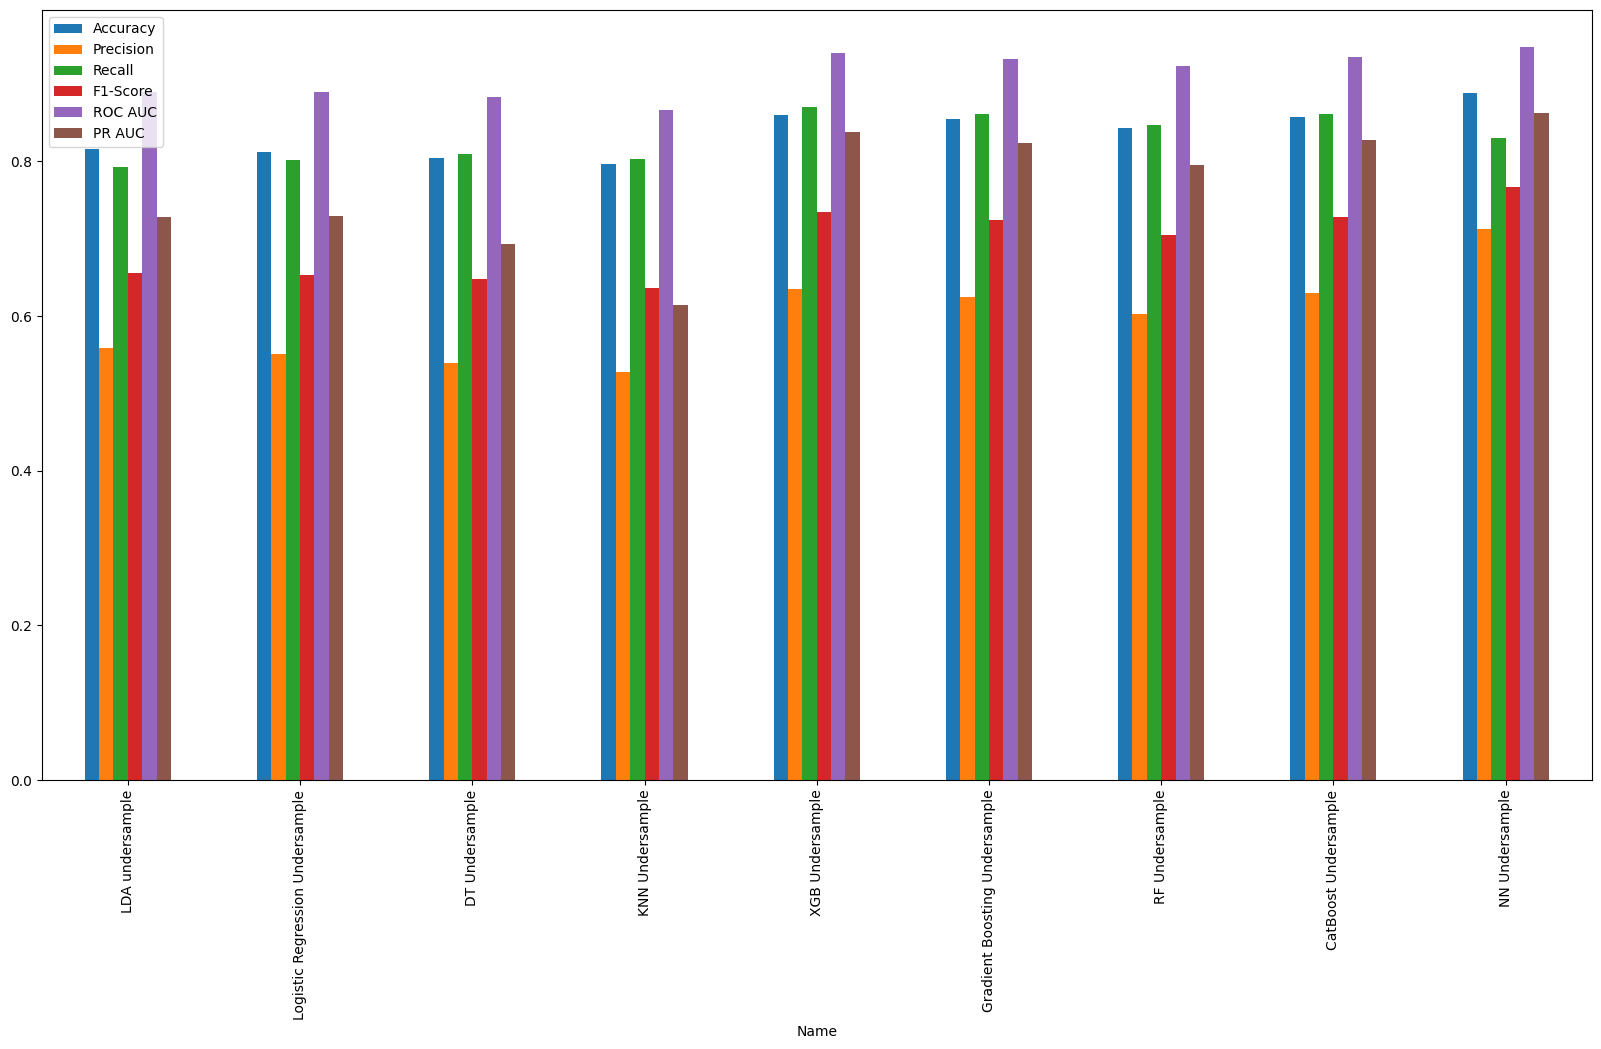

In [453]:
df_under = models_df_under[[x for x in models_df_under.columns if x != 'Confusion Matrix']]
df_under.plot.bar(figsize=(20,10))

In [454]:
for col in models_df_under.columns:
    if col != 'Confusion Matrix':
        print(models_df_under.sort_values(by=col, ascending=False)[col].head(1))

Name
NN Undersample    0.88803
Name: Accuracy, dtype: object
Name
NN Undersample    0.71215
Name: Precision, dtype: object
Name
XGB Undersample    0.870513
Name: Recall, dtype: object
Name
NN Undersample    0.766736
Name: F1-Score, dtype: object
Name
NN Undersample    0.94843
Name: ROC AUC, dtype: object
Name
NN Undersample    0.862111
Name: PR AUC, dtype: object


In [467]:
best_values_under = pd.DataFrame(columns=['Metric', 'Best Value', 'Method'])

for col in models_df_under.columns:
    if col != 'Confusion Matrix':
        best_value_row = models_df_under.sort_values(by=col, ascending=False).head(1)
        best_value = best_value_row[col].values[0]
        method_name = best_value_row.index[0]  # Il nome del metodo dall'indice della riga
        new_row = pd.DataFrame({'Metric': [col], 'Best Value': [best_value], 'Method': [method_name]})
        best_values_under = pd.concat([best_values_under, new_row], ignore_index=True)

pd.DataFrame(best_values_under)


Metric  Best Value           Method
0   Accuracy    0.888030   NN Undersample
1  Precision    0.712150   NN Undersample
2     Recall    0.870513  XGB Undersample
3   F1-Score    0.766736   NN Undersample
4    ROC AUC    0.948430   NN Undersample
5     PR AUC    0.862111   NN Undersample

## Best method for each metrics

In [490]:
# Concatenare i tre DataFrame in uno solo
all_best_values = pd.concat([best_values_no_resample,
                             best_values_smote,
                             best_values_under],
                            ignore_index=True)

# Raggruppare per metrica e selezionare il metodo con il valore massimo
best_method_per_metric = all_best_values.loc[all_best_values.groupby('Metric')['Best Value'].idxmax()]

pd.DataFrame(best_method_per_metric)


Metric  Best Value           Method
0    Accuracy    0.906157   NN No Resample
3    F1-Score    0.776326   NN No Resample
5      PR AUC    0.872792   NN No Resample
1   Precision    0.826346  XGB No Resample
10    ROC AUC    0.951126         NN Smote
14     Recall    0.870513  XGB Undersample

In [500]:
print(models_df['Recall'].mean())
print(models_df_smote['Recall'].mean())
print(models_df_under['Recall'].mean())

0.6381908831908832
0.754871794871795
0.8308404558404558


In [501]:
print(models_df['Precision'].mean())
print(models_df_smote['Precision'].mean())
print(models_df_under['Precision'].mean())

0.7803007326671278
0.6732270061183544
0.5978661139484691


In [502]:
print(models_df['PR AUC'].mean())
print(models_df_smote['PR AUC'].mean())
print(models_df_under['PR AUC'].mean())

0.7880900950576719
0.7606033864397873
0.7677474590713482
